# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install -r requirements.txt

In [2]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import phik


In [3]:
load_dotenv()

# Конфигурация базы данных из переменных окружения
db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

In [5]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    EXTRACT(DAY FROM (p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk))) AS days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases p 
JOIN afisha.events e ON e.event_id = p.event_id
JOIN afisha.city c ON c.city_id = e.city_id
JOIN afisha.regions r ON r.region_id = c.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id;
''' 

In [6]:
df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [7]:
def dataset_info(data):
    """
    Вывод информации о датасете
    """
    from IPython.display import display, HTML, Markdown
    
    display(Markdown("## 🎯 Первые 5 строк датасета"))
    display(data.head())
    
    display(Markdown("## 📊 Основная информация"))
    
    # info()
    display(Markdown("### 📈 Информация о датасете"))
    data.info()
    
    # количество пропусков
    display(Markdown("### 📝 Количество пропусков"))
    missing_data = data.isna().sum()
    if missing_data.sum() == 0:
        display(Markdown("✅ **Нет пропущенных значений**"))
    else:
        display(missing_data[missing_data > 0])
    
   # describe() по типам данных отдельно
    display(Markdown("### 🔢 Числовые колонки (describe)"))
    numeric_data = data.select_dtypes(include='number')
    if not numeric_data.empty:
        display(numeric_data.describe())
    else:
        display(Markdown("*Нет числовых колонок*"))
    
    display(Markdown("### 🏷️ Текстовые колонки (describe)"))
    object_data = data.select_dtypes(include='object')
    if not object_data.empty:
        display(object_data.describe())
    else:
        display(Markdown("*Нет текстовых колонок*"))
    
    display(Markdown("### 📂 Категориальные колонки (describe)"))
    category_data = data.select_dtypes(include='category')
    if not category_data.empty:
        display(category_data.describe())
    else:
        display(Markdown("*Нет категориальных колонок*"))
    
    display(Markdown("### ⚡ Булевы колонки (describe)"))
    bool_data = data.select_dtypes(include='bool')
    if not bool_data.empty:
        display(bool_data.describe())
    else:
        display(Markdown("*Нет булевых колонок*"))
    
    # Уникальные значения для каждого поля
    display(Markdown("## 🎪 Уникальные значения по колонкам"))
    
    for col in data.columns:
        unique_count = data[col].nunique()
        null_count = data[col].isnull().sum()
        dtype = data[col].dtype
        
        display(Markdown(f"### 📍 {col}"))
        
        info_html = f"""
        <div style="
            border: 1px solid #2196F3;
            border-radius: 8px;
            padding: 12px;
            margin: 8px 0;
            background-color: #f0f8ff;
        ">
            <p><b>Тип:</b> {dtype}</p>
            <p><b>Уникальных значений:</b> {unique_count}</p>
            <p><b>Пропусков:</b> {null_count}</p>
        </div>
        """
         
        display(HTML(info_html))
        
        unique_values = data[col].dropna().unique()
        
        if unique_count <= 10:
            display(Markdown(f"**Уникальные значения:** {list(unique_values[:10])}"))
        else:
            display(Markdown(f"**Количество уникальных значений:** {unique_count}"))
            display(Markdown(f"**Примеры 10 значений:** {list(unique_values[:10])}"))
            
        # Вывод min/max для числовых колонок
        if data[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            display(Markdown(f"**Минимум:** {data[col].min()}"))
            display(Markdown(f"**Максимум:** {data[col].max()}"))
        
        print("─" * 50)

In [8]:
dataset_info(df)

## 🎯 Первые 5 строк датасета

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк


## 📊 Основная информация

### 📈 Информация о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

### 📝 Количество пропусков

days_since_prev    21933
dtype: int64

### 🔢 Числовые колонки (describe)

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


### 🏷️ Текстовые колонки (describe)

,user_id,device_type_canonical,currency_code,event_name,service_name,event_type_main,region_name,city_name
count,290611,290611,290611,290611,290611,290611,290611,290611
unique,21933,2,2,15248,36,7,81,352
top,0beb8fc0c0a9ce1,mobile,rub,9cc55c15-4375-4129-9979-3129688ba1b4,Билеты без проблем,концерты,Каменевский регион,Глиногорск
freq,10251,232490,285542,3953,63519,115276,91058,89446


### 📂 Категориальные колонки (describe)

*Нет категориальных колонок*

### ⚡ Булевы колонки (describe)

*Нет булевых колонок*

## 🎪 Уникальные значения по колонкам

### 📍 user_id

**Количество уникальных значений:** 21933

**Примеры 10 значений:** ['0002849b70a3ce2', '0005ca5e93f2cf4', '000898990054619', '00096d1f542ab2b', '000a55a418c128c', '000cf0659a9f40f', '00147c9209d45d3', '0018ecd8a38a51b', '00199a573901564', '001e7037d013f0f']

──────────────────────────────────────────────────


### 📍 device_type_canonical

**Уникальные значения:** ['mobile', 'desktop']

──────────────────────────────────────────────────


### 📍 order_id

**Количество уникальных значений:** 290611

**Примеры 10 значений:** [np.int64(4359165), np.int64(7965605), np.int64(7292370), np.int64(1139875), np.int64(972400), np.int64(2613713), np.int64(6636941), np.int64(4657981), np.int64(4657952), np.int64(6818191)]

**Минимум:** 1

**Максимум:** 8653108

──────────────────────────────────────────────────


### 📍 order_dt

**Количество уникальных значений:** 153

**Примеры 10 значений:** [Timestamp('2024-08-20 00:00:00'), Timestamp('2024-07-23 00:00:00'), Timestamp('2024-10-06 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-10-04 00:00:00'), Timestamp('2024-10-23 00:00:00'), Timestamp('2024-08-15 00:00:00'), Timestamp('2024-09-29 00:00:00'), Timestamp('2024-10-15 00:00:00'), Timestamp('2024-06-20 00:00:00')]

──────────────────────────────────────────────────


### 📍 order_ts

**Количество уникальных значений:** 280753

**Примеры 10 значений:** [Timestamp('2024-08-20 16:08:03'), Timestamp('2024-07-23 18:36:24'), Timestamp('2024-10-06 13:56:02'), Timestamp('2024-07-13 19:40:48'), Timestamp('2024-10-04 22:33:15'), Timestamp('2024-10-23 15:12:00'), Timestamp('2024-08-15 16:48:48'), Timestamp('2024-09-29 19:39:12'), Timestamp('2024-10-15 10:29:04'), Timestamp('2024-06-20 10:51:10')]

──────────────────────────────────────────────────


### 📍 currency_code

**Уникальные значения:** ['rub', 'kzt']

──────────────────────────────────────────────────


### 📍 revenue

**Количество уникальных значений:** 42522

**Примеры 10 значений:** [np.float64(1521.94), np.float64(289.45), np.float64(1258.57), np.float64(8.49), np.float64(1390.41), np.float64(902.74), np.float64(917.83), np.float64(47.78), np.float64(74.84), np.float64(1421.91)]

**Минимум:** -90.76

**Максимум:** 81174.54

──────────────────────────────────────────────────


### 📍 tickets_count

**Количество уникальных значений:** 22

**Примеры 10 значений:** [np.int64(4), np.int64(2), np.int64(3), np.int64(1), np.int64(5), np.int64(6), np.int64(10), np.int64(9), np.int64(7), np.int64(15)]

**Минимум:** 1

**Максимум:** 57

──────────────────────────────────────────────────


### 📍 days_since_prev

**Количество уникальных значений:** 149

**Примеры 10 значений:** [np.float64(75.0), np.float64(83.0), np.float64(19.0), np.float64(16.0), np.float64(0.0), np.float64(1.0), np.float64(74.0), np.float64(13.0), np.float64(25.0), np.float64(30.0)]

**Минимум:** 0.0

**Максимум:** 148.0

──────────────────────────────────────────────────


### 📍 event_id

**Количество уникальных значений:** 22427

**Примеры 10 значений:** [np.int64(169230), np.int64(237325), np.int64(578454), np.int64(387271), np.int64(509453), np.int64(500862), np.int64(201953), np.int64(265857), np.int64(271579), np.int64(516728)]

**Минимум:** 4436

**Максимум:** 592325

──────────────────────────────────────────────────


### 📍 event_name

**Количество уникальных значений:** 15248

**Примеры 10 значений:** ['f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad', '40efeb04-81b7-4135-b41f-708ff00cc64c', '01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca', '2f638715-8844-466c-b43f-378a627c419f', '10d805d3-9809-4d8a-834e-225b7d03f95d', '9cc55c15-4375-4129-9979-3129688ba1b4', '2f98d69f-4e60-4ffc-8f16-e539383526b1', '0d876e01-851e-458b-ba61-753e0e0c4063', 'ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1', '11be386f-7cb7-4aa1-a8e4-ba73a29c1af2']

──────────────────────────────────────────────────


### 📍 service_name

**Количество уникальных значений:** 36

**Примеры 10 значений:** ['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!', 'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная', 'Быстробилет', 'Дом культуры']

──────────────────────────────────────────────────


### 📍 event_type_main

**Уникальные значения:** ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']

──────────────────────────────────────────────────


### 📍 region_name

**Количество уникальных значений:** 81

**Примеры 10 значений:** ['Каменевский регион', 'Североярская область', 'Озернинский край', 'Лугоградская область', 'Поленовский край', 'Широковская область', 'Медовская область', 'Златопольский округ', 'Малиновоярский округ', 'Яблоневская область']

──────────────────────────────────────────────────


### 📍 city_name

**Количество уникальных значений:** 352

**Примеры 10 значений:** ['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск', 'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай', 'Верховино', 'Светополье']

──────────────────────────────────────────────────


---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

print('количество строк:', tenge_df.shape[0])
print('\nпервые 5:')
tenge_df.head()

количество строк: 357

первые 5:


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [10]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Признак `data` имеет формат object.  
Необходимо ее преобразовать в datetime для дальнейшего сравнения с датами в основном датасете df

In [11]:
# новый признак - курс "тенге к рублю"
tenge_df['tange_rate'] = 100 / tenge_df['curs']

rates_tenge_df = tenge_df[['data', 'tange_rate']].copy()

rates_tenge = rates_tenge_df.set_index('data')['tange_rate']
# индекс rates_tenge в datetime
rates_tenge.index = pd.to_datetime(rates_tenge.index)

rates_tenge.sample(5)

data
2024-03-30    4.851896
2024-12-10    5.178825
2024-03-01    4.968055
2024-04-16    4.785697
2024-04-28    4.830615
Name: tange_rate, dtype: float64

Создадим новый признак в датасете df  "revenue_rub":
- для kzt: `revenue * курс на дату заказа` 
- для rub: `оставляем revenue`

In [12]:

df['revenue_rub'] = np.where(
    df['currency_code'] == 'kzt',
    round(df['revenue'] * df['order_dt'].map(rates_tenge), 2),
    df['revenue']
)

In [13]:
# пример для контроля нового признака  'revenue_rub'
sample_df = df[df['currency_code'] == 'kzt'].sample(5).copy()

print(sample_df[['order_dt', 'revenue', 'currency_code', 'revenue_rub']])

         order_dt  revenue currency_code  revenue_rub
152762 2024-06-11  8808.62           kzt     44280.44
249886 2024-06-11  6892.13           kzt     34646.35
188427 2024-06-04  1849.41           kzt      9254.78
7268   2024-06-11  8808.62           kzt     44280.44
234052 2024-06-06  2106.20           kzt     10632.86


In [14]:
print('Количество пропусков "revenue_rub" =', df.revenue_rub.isna().sum())

Количество пропусков "revenue_rub" = 0


в `final_tickets_tenge_df.csv` предсталены все даты как и в основном датасете, поэтому пропусков в новом признаке нет.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [15]:
print('Количество пропусков в df:')
print('-' * 30)
df.isna().sum()

Количество пропусков в df:
------------------------------


user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

In [17]:
print("Память (MB):", df.memory_usage(deep=True).sum() / 1024**2)

Память (MB): 214.22012996673584


In [18]:
for col in df.select_dtypes(include=['int64']).columns:
    col_min = df[col].min()
    col_max = df[col].max()
    print(f"{col}: min={col_min}, max={col_max}")

order_id: min=1, max=8653108
tickets_count: min=1, max=57
event_id: min=4436, max=592325


In [19]:
# order_id: 1 до 8,653,108 → int32
df['order_id'] = df['order_id'].astype('int32')

# tickets_count: 1 до 57 → int8
df['tickets_count'] = df['tickets_count'].astype('int8')

# event_id: 4436 до 592,325 → int32
df['event_id'] = df['event_id'].astype('int32')

In [20]:
# revenue и revenue_rub: float64 → float32
df['revenue'] = df['revenue'].astype('float32')
df['revenue_rub'] = df['revenue_rub'].astype('float32')

# days_since_prev: float64 → float32
df['days_since_prev'] = df['days_since_prev'].astype('float32')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

In [22]:
print("Память (MB):", df.memory_usage(deep=True).sum() / 1024**2)

Память (MB): 206.73712730407715


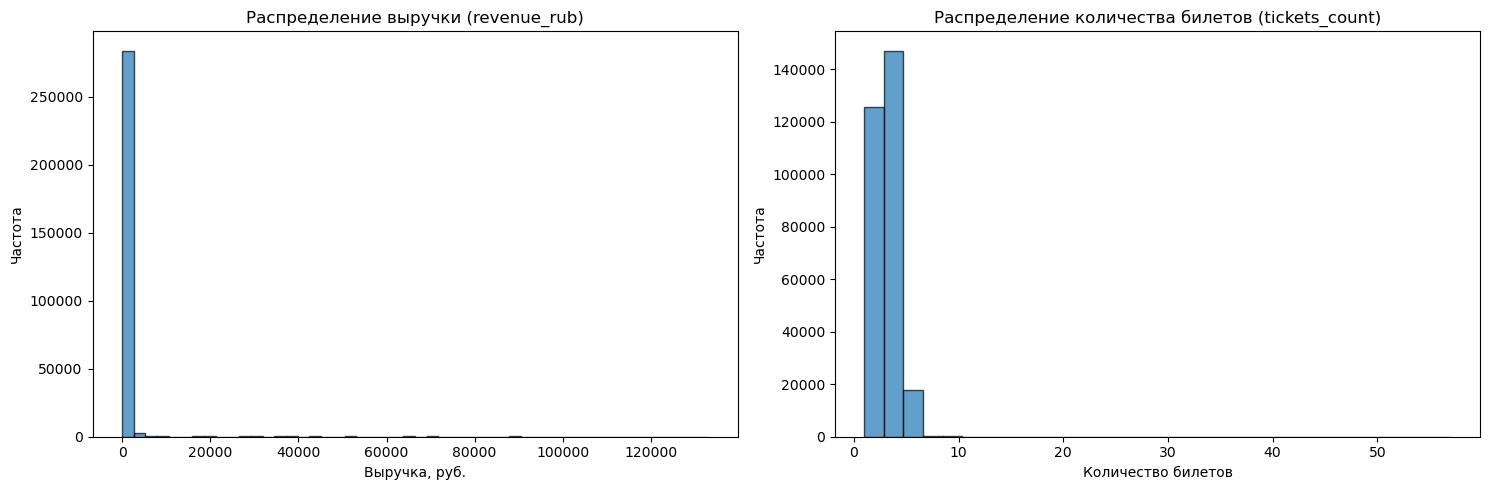

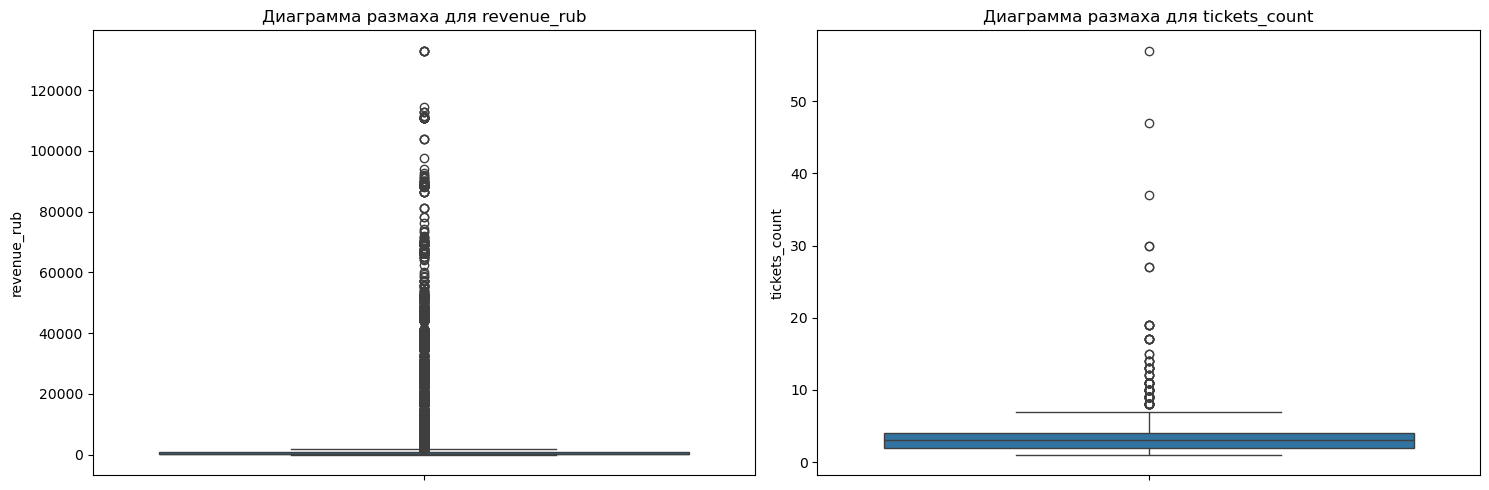

In [23]:
# гистограмма
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['revenue_rub'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение выручки (revenue_rub)')
axes[0].set_xlabel('Выручка, руб.')
axes[0].set_ylabel('Частота')

axes[1].hist(df['tickets_count'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Распределение количества билетов (tickets_count)')
axes[1].set_xlabel('Количество билетов')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, y='revenue_rub', ax=axes[0])
axes[0].set_title('Диаграмма размаха для revenue_rub')

sns.boxplot(data=df, y='tickets_count', ax=axes[1])
axes[1].set_title('Диаграмма размаха для tickets_count')

plt.tight_layout()
plt.show()

In [24]:
# Статистики для выявления выбросов
print("Описательные статистики для revenue_rub:\n")
print(df['revenue_rub'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

Описательные статистики для revenue_rub:

count    290611.000000
mean        982.315918
std        4702.125000
min         -90.760002
25%         116.989998
50%         359.369995
75%         822.609985
90%        1348.310059
95%        1803.140015
99%       18241.240234
max      133023.890625
Name: revenue_rub, dtype: float64


**Анализ распределения ключевых показателей:**

`Для revenue_rub:`
- Среднее: 982 руб.
- Медиана: 359 руб. (сильный перекос вправо)
- 99-й перцентиль: 18,241 руб.
- Максимум: 133,024 руб.
- Минимум: -90.76 руб. (отрицательные значения - требуют внимания)

`Для tickets_count:`
- Диапазон от 1 до 57 билетов

In [25]:
# Фильтр по 99-му перцентилю
revenue_threshold = df['revenue_rub'].quantile(0.99)

# Фильтруем выбросы
df_clean = df[df['revenue_rub'] <= revenue_threshold]

# Убираем отрицательные значения выручки
df_clean = df_clean[df_clean['revenue_rub'] >= 0]

In [26]:
print(f"99-й перцентиль: {revenue_threshold:.2f} руб.")
print(f"Отфильтровано записей: {len(df) - len(df_clean)}")
print(f"Осталось записей: {len(df_clean)}")
print(f"Процент отфильтрованных данных: {(len(df) - len(df_clean)) / len(df) * 100:.2f}%")

99-й перцентиль: 18241.24 руб.
Отфильтровано записей: 3186
Осталось записей: 287425
Процент отфильтрованных данных: 1.10%


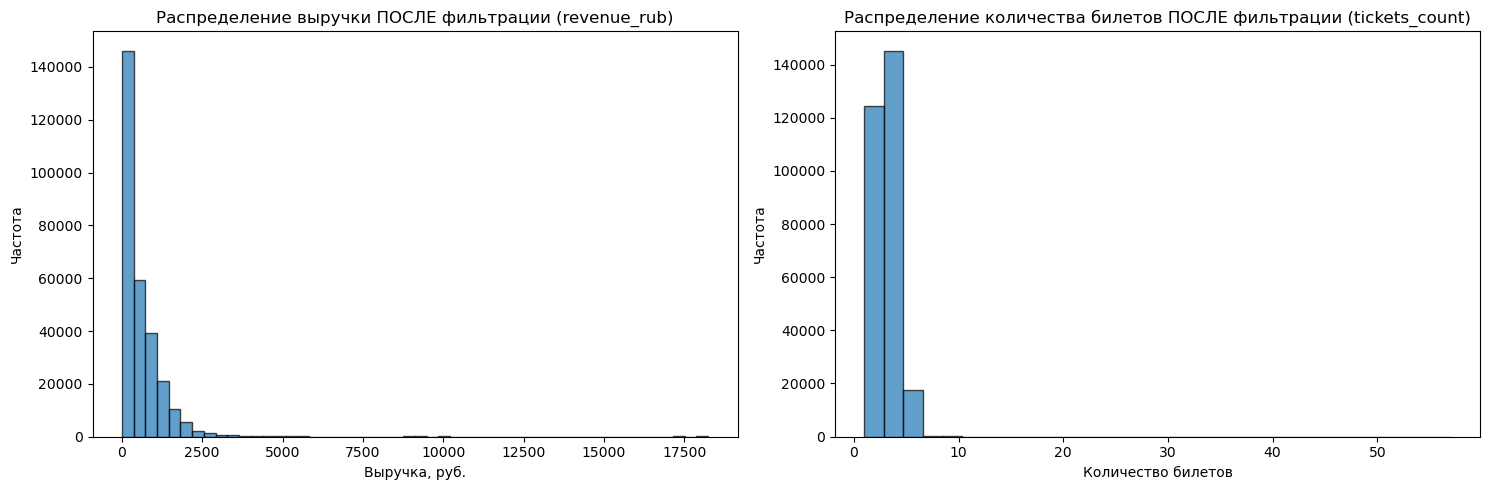

In [27]:
# Визуализация после фильтрации
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_clean['revenue_rub'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение выручки ПОСЛЕ фильтрации (revenue_rub)')
axes[0].set_xlabel('Выручка, руб.')
axes[0].set_ylabel('Частота')

axes[1].hist(df_clean['tickets_count'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Распределение количества билетов ПОСЛЕ фильтрации (tickets_count)')
axes[1].set_xlabel('Количество билетов')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [28]:
# Статистики после фильтрации
df_clean.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id,revenue_rub
count,2.874250e+05,287425,287425,287425.000000,287425.000000,265984.000000,287425.000000,287425.000000
mean,4.325479e+06,2024-09-02 13:30:31.995129600,2024-09-03 04:25:32.288273920,543.447937,2.753598,3.232544,436998.830711,575.926270
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,0.000000,1.000000,0.000000,4436.000000,0.000000
25%,2.160849e+06,2024-07-31 00:00:00,2024-07-31 11:51:57,116.269997,2.000000,0.000000,357306.000000,116.449997
50%,4.326714e+06,2024-09-12 00:00:00,2024-09-12 22:37:14,349.250000,3.000000,0.000000,494565.000000,354.350006
75%,6.487156e+06,2024-10-09 00:00:00,2024-10-09 20:12:52,796.099976,4.000000,1.000000,547166.000000,805.109985
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,18093.640625,57.000000,148.000000,592325.000000,18241.240234
std,2.498085e+06,NaN,NaN,602.021973,1.172879,11.359645,147853.479389,854.055359


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [29]:
# Сортируем данные по времени заказа
df_sorted = df_clean.sort_values(['user_id', 'order_ts'])

# профиль пользователя
user_profile = df_sorted.groupby('user_id').agg({
    'order_dt': ['min', 'max'],
    'device_type_canonical': 'first',
    'region_name': 'first',
    'service_name': 'first',
    'event_type_main': 'first',
    'order_id': 'count',
    'revenue_rub': lambda x: round(x.mean(), 2),
    'tickets_count': lambda x: round(x.mean(), 2),
    'days_since_prev': lambda x: round(x.mean(), 2)
})

# Переименовываем колонки
user_profile.columns = [
    'first_order_dt',
    'last_order_dt', 
    'first_device',
    'first_region',
    'first_service',
    'first_event_type',
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders'
]

user_profile = user_profile.reset_index()

user_profile['total_orders'] = user_profile['total_orders'].astype('int16') 
user_profile['avg_tickets_count'] = user_profile['avg_tickets_count'].astype('int8') 

# Добавляем бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype('int8')
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype('int8')

# Настраиваем отображение
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.precision', 2)

user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3,75.00,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2,51.00,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1,16.00,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [30]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21719 entries, 0 to 21718
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21719 non-null  object        
 1   first_order_dt           21719 non-null  datetime64[ns]
 2   last_order_dt            21719 non-null  datetime64[ns]
 3   first_device             21719 non-null  object        
 4   first_region             21719 non-null  object        
 5   first_service            21719 non-null  object        
 6   first_event_type         21719 non-null  object        
 7   total_orders             21719 non-null  int16         
 8   avg_revenue_rub          21719 non-null  float32       
 9   avg_tickets_count        21719 non-null  int8          
 10  avg_days_between_orders  13462 non-null  float64       
 11  is_two                   21719 non-null  int8          
 12  is_five                  21719 n

📊 БАЗОВЫЕ МЕТРИКИ:

In [31]:
print(f"1. Общее число пользователей: {len(user_profile):,}")

avg_revenue = user_profile['avg_revenue_rub'].mean()
print(f"2. Средняя выручка с одного заказа: {avg_revenue:.2f} руб.")

users_two_plus = user_profile['is_two'].mean()
print(f"3. Доля пользователей с 2+ заказами: {users_two_plus:.2%} ({user_profile['is_two'].sum():,} чел.)")

users_five_plus = user_profile['is_five'].mean()
print(f"4. Доля пользователей с 5+ заказами: {users_five_plus:.2%} ({user_profile['is_five'].sum():,} чел.)")

1. Общее число пользователей: 21,719
2. Средняя выручка с одного заказа: 655.43 руб.
3. Доля пользователей с 2+ заказами: 61.75% (13,412 чел.)
4. Доля пользователей с 5+ заказами: 29.12% (6,324 чел.)


📈 СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:

In [32]:
print("ОБЩЕЕ ЧИСЛО ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ:")
print(user_profile['total_orders'].describe())

print("\nСРЕДНЕЕ ЧИСЛО БИЛЕТОВ В ЗАКАЗЕ:")
print(user_profile['avg_tickets_count'].describe())

users_multiple_orders = user_profile[user_profile['total_orders'] >= 2]
print(f"\nСРЕДНЕЕ КОЛИЧЕСТВО ДНЕЙ МЕЖДУ ПОКУПКАМИ\n(для {len(users_multiple_orders):,} пользователей с 2+ заказами):")
print(users_multiple_orders['avg_days_between_orders'].describe())

ОБЩЕЕ ЧИСЛО ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ:
count   21719.00
mean       13.23
std       122.22
min         1.00
25%         1.00
50%         2.00
75%         5.00
max     10195.00
Name: total_orders, dtype: float64

СРЕДНЕЕ ЧИСЛО БИЛЕТОВ В ЗАКАЗЕ:
count   21719.00
mean        2.52
std         0.97
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        12.00
Name: avg_tickets_count, dtype: float64

СРЕДНЕЕ КОЛИЧЕСТВО ДНЕЙ МЕЖДУ ПОКУПКАМИ
(для 13,412 пользователей с 2+ заказами):
count   13412.00
mean       15.87
std        22.27
min         0.00
25%         1.00
50%         8.12
75%        20.50
max       148.00
Name: avg_days_between_orders, dtype: float64


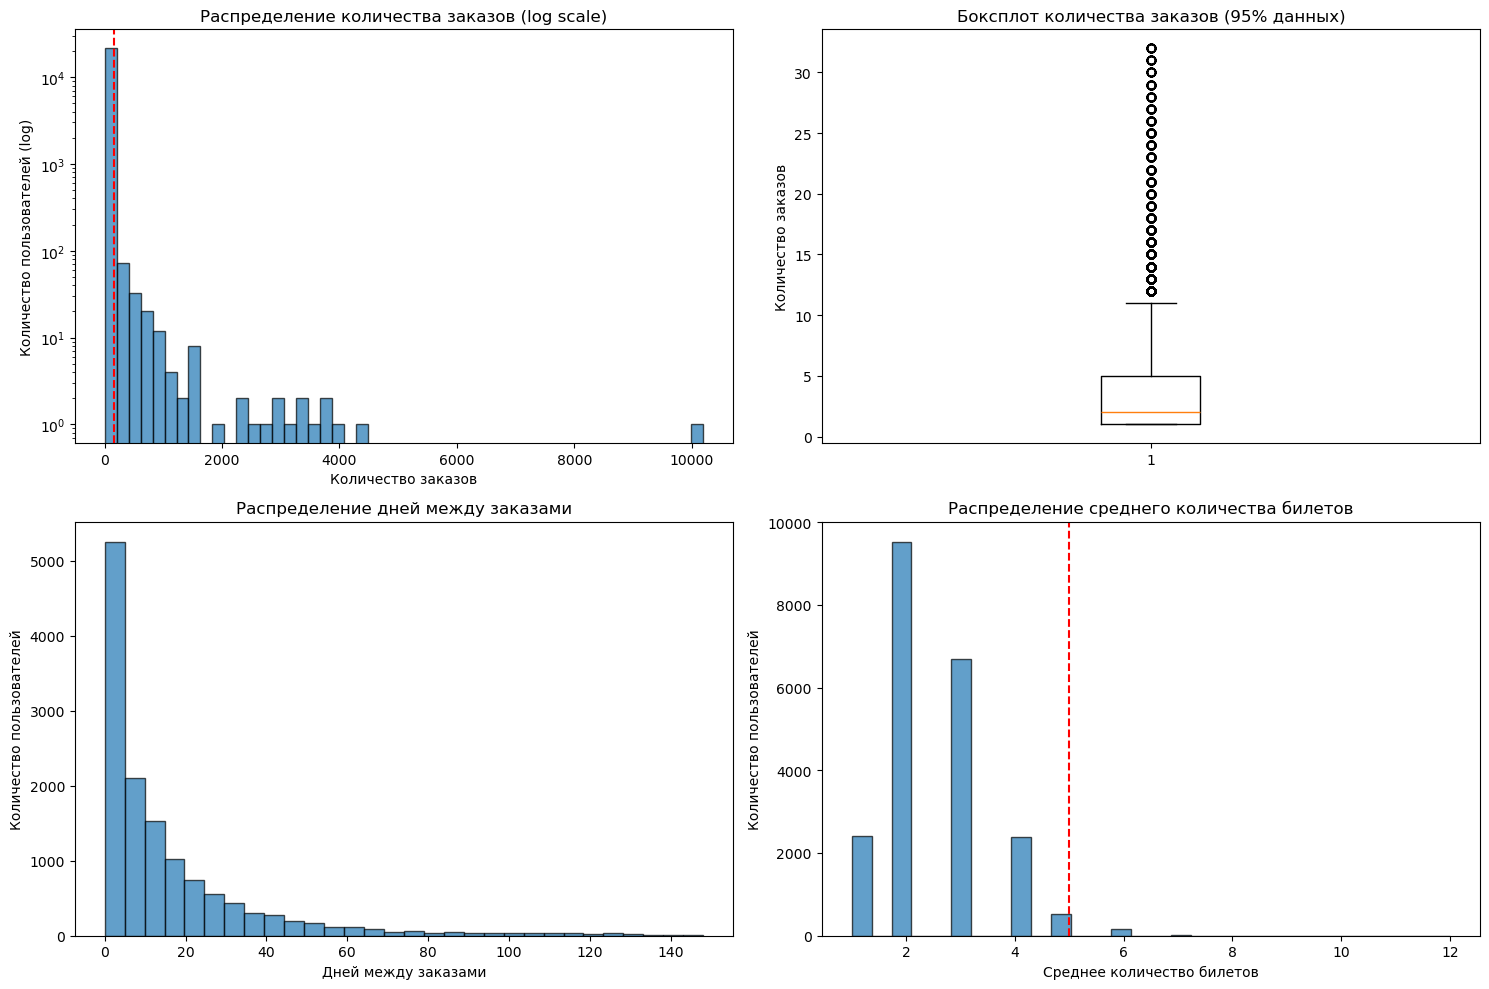

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение количества заказов (логарифмическая шкала)
axes[0,0].hist(user_profile['total_orders'], bins=50, edgecolor='black', alpha=0.7, log=True)
axes[0,0].set_title('Распределение количества заказов (log scale)')
axes[0,0].set_xlabel('Количество заказов')
axes[0,0].set_ylabel('Количество пользователей (log)')
axes[0,0].axvline(user_profile['total_orders'].quantile(0.99), color='red', linestyle='--', label='99-й перцентиль')

# 2. Боксплот количества заказов (без выбросов)
data_to_plot = user_profile[user_profile['total_orders'] <= user_profile['total_orders'].quantile(0.95)]['total_orders']
axes[0,1].boxplot(data_to_plot)
axes[0,1].set_title('Боксплот количества заказов (95% данных)')
axes[0,1].set_ylabel('Количество заказов')

# 3. Распределение дней между заказами (без inf)
days_data = users_multiple_orders[~np.isinf(users_multiple_orders['avg_days_between_orders'])]
axes[1,0].hist(days_data['avg_days_between_orders'], bins=30, edgecolor='black', alpha=0.7)
axes[1,0].set_title('Распределение дней между заказами')
axes[1,0].set_xlabel('Дней между заказами')
axes[1,0].set_ylabel('Количество пользователей')

# 4. Распределение среднего количества билетов
axes[1,1].hist(user_profile['avg_tickets_count'], bins=30, edgecolor='black', alpha=0.7)
axes[1,1].set_title('Распределение среднего количества билетов')
axes[1,1].set_xlabel('Среднее количество билетов')
axes[1,1].set_ylabel('Количество пользователей')
axes[1,1].axvline(user_profile['avg_tickets_count'].quantile(0.99), color='red', linestyle='--', label='99-й перцентиль')

plt.tight_layout()
plt.show()

🔍 АНАЛИЗ АНОМАЛИЙ И ПРИНЯТИЕ РЕШЕНИЯ:

In [34]:
# 1. Анализ выбросов в количестве заказов
print("1. КОЛИЧЕСТВО ЗАКАЗОВ:")
orders_95 = user_profile['total_orders'].quantile(0.95)
orders_99 = user_profile['total_orders'].quantile(0.99)
orders_max = user_profile['total_orders'].max()

print(f"   95-й перцентиль: {orders_95:.0f} заказов")
print(f"   99-й перцентиль: {orders_99:.0f} заказов") 
print(f"   Максимум: {orders_max:.0f} заказов")

extreme_orders = user_profile[user_profile['total_orders'] > orders_99]
print(f"   Пользователей с >99-го перцентиля: {len(extreme_orders):,}")

# 2. Анализ выбросов в количестве билетов
print(f"\n2. КОЛИЧЕСТВО БИЛЕТОВ:")
tickets_95 = user_profile['avg_tickets_count'].quantile(0.95)
tickets_99 = user_profile['avg_tickets_count'].quantile(0.99)
tickets_max = user_profile['avg_tickets_count'].max()

print(f"   95-й перцентиль: {tickets_95:.2f} билетов")
print(f"   99-й перцентиль: {tickets_99:.2f} билетов")
print(f"   Максимум: {tickets_max:.2f} билетов")

extreme_tickets = user_profile[user_profile['avg_tickets_count'] > tickets_99]
print(f"   Пользователей с >99-го перцентиля: {len(extreme_tickets):,}")

# 3. Анализ пользователей с 0 дней между заказами
print(f"\n3. ВРЕМЯ МЕЖДУ ЗАКАЗАМИ:")
zero_days_users = users_multiple_orders[users_multiple_orders['avg_days_between_orders'] == 0]
print(f"   Пользователей с 0 дней между заказами: {len(zero_days_users):,}")
print(f"   Среднее количество заказов у них: {zero_days_users['total_orders'].mean():.1f}")

1. КОЛИЧЕСТВО ЗАКАЗОВ:
   95-й перцентиль: 32 заказов
   99-й перцентиль: 152 заказов
   Максимум: 10195 заказов
   Пользователей с >99-го перцентиля: 218

2. КОЛИЧЕСТВО БИЛЕТОВ:
   95-й перцентиль: 4.00 билетов
   99-й перцентиль: 5.00 билетов
   Максимум: 12.00 билетов
   Пользователей с >99-го перцентиля: 161

3. ВРЕМЯ МЕЖДУ ЗАКАЗАМИ:
   Пользователей с 0 дней между заказами: 2,690
   Среднее количество заказов у них: 3.0


Фильтруем только по количеству заказов (>152), что составляет 1% данных. Это 99-й перцентиль.  
Распределение количества билетов и дней между заказами имеют реальное поведение.


In [35]:
# Фильтруем данные по рассчитанному 99-му перцентилю
user_profile_clean = user_profile[user_profile['total_orders'] <= orders_99]

In [36]:
user_profile_clean.describe()

,first_order_dt,last_order_dt,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
count,21501,21501,21501.00,21501.00,21501.00,13244.00,21501.00,21501.00
mean,2024-08-11 06:27:46.638760960,2024-09-18 11:08:35.864378368,6.50,656.41,2.53,16.25,0.61,0.28
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.00,0.00,1.00,0.00,0.00,0.00
25%,2024-06-27 00:00:00,2024-08-25 00:00:00,1.00,220.70,2.00,1.40,0.00,0.00
50%,2024-08-10 00:00:00,2024-10-03 00:00:00,2.00,485.44,2.00,8.50,1.00,0.00
75%,2024-09-23 00:00:00,2024-10-22 00:00:00,5.00,813.88,3.00,21.00,1.00,1.00
max,2024-10-31 00:00:00,2024-10-31 00:00:00,151.00,18241.24,12.00,148.00,1.00,1.00
std,NaN,NaN,14.26,996.61,0.97,22.56,0.49,0.45


Данные успешно очищены от экстремальных выбросов, сохраняя 99% информации.  
Все распределения отражают реальное поведение пользователей.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


📊 РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ:

In [37]:
print("1. ТИП ПЕРВОГО МЕРОПРИЯТИЯ:")

event_type_dist = user_profile_clean['first_event_type'].value_counts()
event_type_pct = user_profile_clean['first_event_type'].value_counts(normalize=True) * 100

event_type_summary = pd.DataFrame({
    'Количество': event_type_dist,
    'Доля, %': event_type_pct.round(2)
})

print(f"\nВсего уникальных категорий: {user_profile_clean['first_event_type'].nunique()}")

event_type_summary

1. ТИП ПЕРВОГО МЕРОПРИЯТИЯ:

Всего уникальных категорий: 7


,Количество,"Доля, %"
first_event_type,,
концерты,9291,43.21
другое,5476,25.47
театр,4301,20.00
стендап,1122,5.22
спорт,805,3.74
выставки,411,1.91
ёлки,95,0.44


In [38]:
print("\n2. ТИП УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ:")

device_dist = user_profile_clean['first_device'].value_counts()
device_pct = user_profile_clean['first_device'].value_counts(normalize=True) * 100

device_summary = pd.DataFrame({
    'Количество': device_dist,
    'Доля, %': device_pct.round(2)
})

device_summary


2. ТИП УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ:


,Количество,"Доля, %"
first_device,,
mobile,17827,82.91
desktop,3674,17.09


In [39]:
print("\n3. РЕГИОН ПРОВЕДЕНИЯ МЕРОПРИЯТИЯ(Топ 10):")

region_top_10 = user_profile_clean['first_region'].value_counts().head(10)
region_pct = (region_top_10 / len(user_profile_clean)) * 100

region_summary = pd.DataFrame({
    'Количество': region_top_10,
    'Доля, %': region_pct.round(2)
})

print(f"\nВсего уникальных регионов: {user_profile_clean['first_region'].nunique()}")

region_summary


3. РЕГИОН ПРОВЕДЕНИЯ МЕРОПРИЯТИЯ(Топ 10):

Всего уникальных регионов: 81


,Количество,"Доля, %"
first_region,,
Каменевский регион,7182,33.40
Североярская область,3796,17.65
Широковская область,1240,5.77
Озернинский край,683,3.18
Малиновоярский округ,541,2.52
Травяная область,491,2.28
Светополянский округ,473,2.20
Речиновская область,441,2.05
Яблоневская область,415,1.93


In [40]:
# 4. Распределение по билетному оператору
print("\n4. БИЛЕТНЫЙ ОПЕРАТОР ПЕРВОГО ЗАКАЗА:")

service_dist = user_profile_clean['first_service'].value_counts()
service_pct = user_profile_clean['first_service'].value_counts(normalize=True) * 100

service_summary = pd.DataFrame({
    'Количество': service_dist,
    'Доля, %': service_pct.round(2)
})

print(f"\nВсего уникальных операторов: {user_profile_clean['first_service'].nunique()}")

service_summary


4. БИЛЕТНЫЙ ОПЕРАТОР ПЕРВОГО ЗАКАЗА:

Всего уникальных операторов: 34


,Количество,"Доля, %"
first_service,,
Билеты без проблем,5197,24.17
Лови билет!,2845,13.23
Мой билет,2671,12.42
Билеты в руки,2569,11.95
Облачко,2203,10.25
Весь в билетах,1313,6.11
Лучшие билеты,1187,5.52
Прачечная,594,2.76
Край билетов,458,2.13


🎯 КЛЮЧЕВЫЕ СЕГМЕНТЫ-ЛИДЕРЫ:


1. КОНЦЕРТЫ - 43.2% всех первых заказов
2. MOBILE - 82.9% пользователей начинают с мобильных устройств
3. КАМЕНЕВСКИЙ РЕГИОН - 33.4% пользователей (доминирующий регион)
4. БИЛЕТЫ БЕЗ ПРОБЛЕМ - 24.2% пользователей (крупнейший оператор)

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


📊 АНАЛИЗ ВОЗВРАТОВ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ:

In [41]:
overall_retention = user_profile_clean['is_two'].mean()
print(f"Общая доля пользователей с 2+ заказами: {overall_retention:.2%}")

Общая доля пользователей с 2+ заказами: 61.36%


In [42]:
def analyze_segment_retention(segment_column, min_users=1000, top_n=10):
    """Расчет и визуализация статистик возврата по сегментам."""
    
    print(f"\nТоп-{top_n} по {segment_column} пользователей c 2 и более заказами:")
    print("-" * 45)
    
    segment_stats = user_profile_clean.groupby(segment_column).agg({
        'user_id': 'count',
        'is_two': 'mean'
    }).rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'}).reset_index()
    
    segment_stats = segment_stats.sort_values('total_users', ascending=False).head(top_n)
    segment_stats['retention_rate_pct'] = (segment_stats['retention_rate'] * 100).round(2)
    
    display(segment_stats[[segment_column, 'total_users', 'retention_rate_pct']])
    
    # Успешные точки входа (retention > чем в среднем по выборке)
    success_entry_points = segment_stats[
        (segment_stats['total_users'] >= min_users) & 
        (segment_stats['retention_rate'] >= overall_retention)
    ]
    
    # визуализация
    fig, ax = plt.subplots(figsize=(10, 8))
    
    segment_stats_sorted = segment_stats.sort_values('retention_rate', ascending=True)
    
    ax.barh(range(len(segment_stats_sorted)), 
            segment_stats_sorted['retention_rate'] * 100,
            color=['lightcoral' if x <= overall_retention else 'lightgreen' 
                   for x in segment_stats_sorted['retention_rate']])

    ax.set_yticks(range(len(segment_stats_sorted)))
    ax.set_yticklabels(segment_stats_sorted[segment_column])
    ax.set_xlabel('Доля пользователей с 2+ заказами, %', fontsize=12)
    ax.set_title(f'Доля возвратов по {segment_column}', fontsize=14, fontweight='bold')

    # линия среднего значения
    ax.axvline(overall_retention * 100, color='red', linestyle='--', 
               label=f'Среднее по сегменту: {overall_retention:.1%}')
    ax.legend()

    # аннотации с количеством пользователей
    for i, (_, row) in enumerate(segment_stats_sorted.iterrows()):
        ax.text(row['retention_rate'] * 100 - 10, i, 
                 f"{row['total_users']:,}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return success_entry_points


Топ-10 по first_event_type пользователей c 2 и более заказами:
---------------------------------------------


,first_event_type,total_users,retention_rate_pct
2,концерты,9291,61.75
1,другое,5476,59.70
5,театр,4301,63.66
4,стендап,1122,61.05
3,спорт,805,55.90
0,выставки,411,63.99
6,ёлки,95,54.74


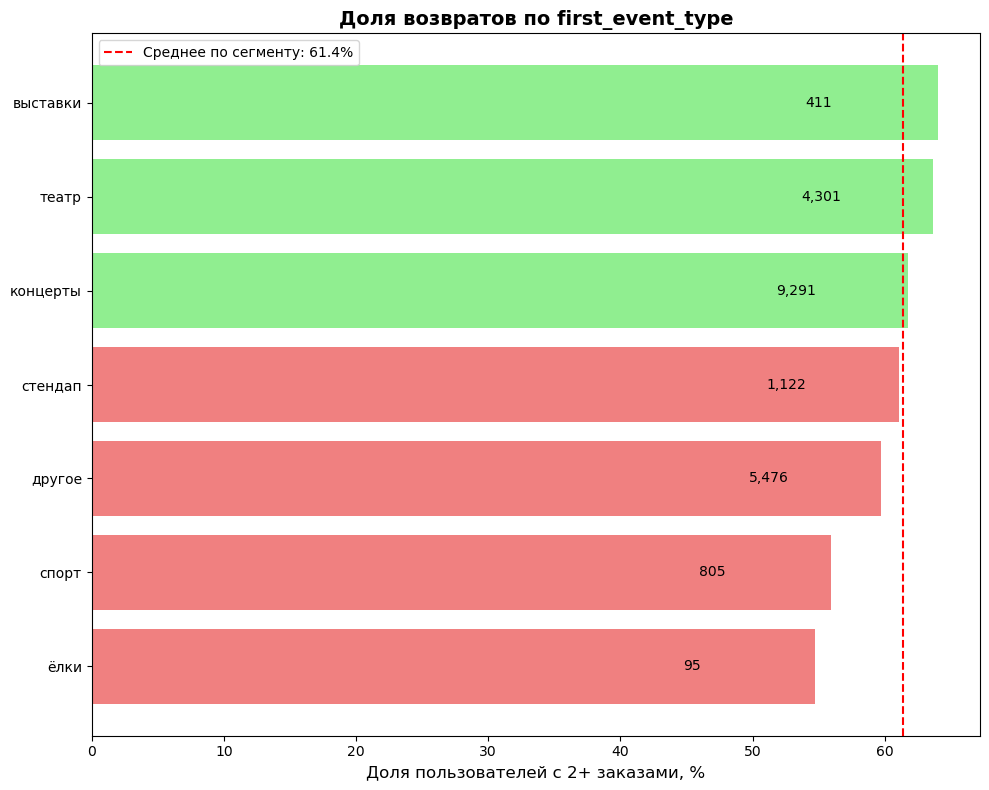

In [43]:
event_retention = analyze_segment_retention('first_event_type')


Топ-10 по first_device пользователей c 2 и более заказами:
---------------------------------------------


,first_device,total_users,retention_rate_pct
1,mobile,17827,60.91
0,desktop,3674,63.58


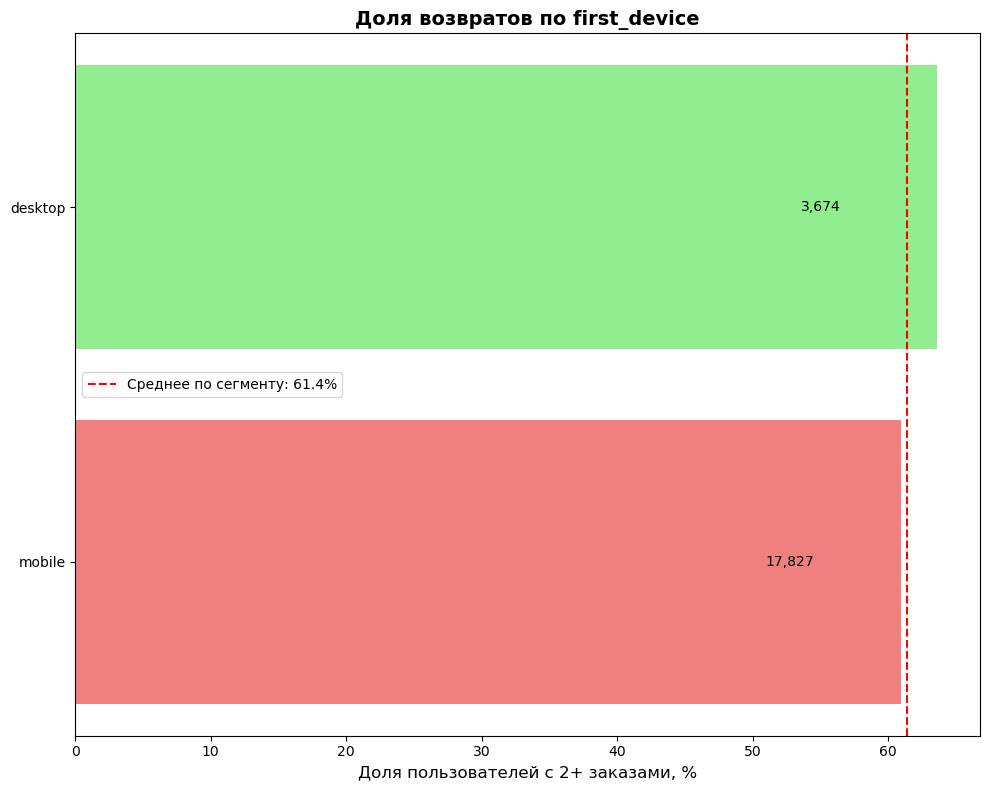

In [44]:
device_retention = analyze_segment_retention('first_device')


Топ-10 по first_region пользователей c 2 и более заказами:
---------------------------------------------


,first_region,total_users,retention_rate_pct
23,Каменевский регион,7182,62.59
60,Североярская область,3796,64.12
77,Широковская область,1240,64.84
45,Озернинский край,683,55.34
41,Малиновоярский округ,541,56.56
74,Травяная область,491,61.71
57,Светополянский округ,473,66.38
52,Речиновская область,441,63.95
78,Яблоневская область,415,59.52
42,Медовская область,375,59.47


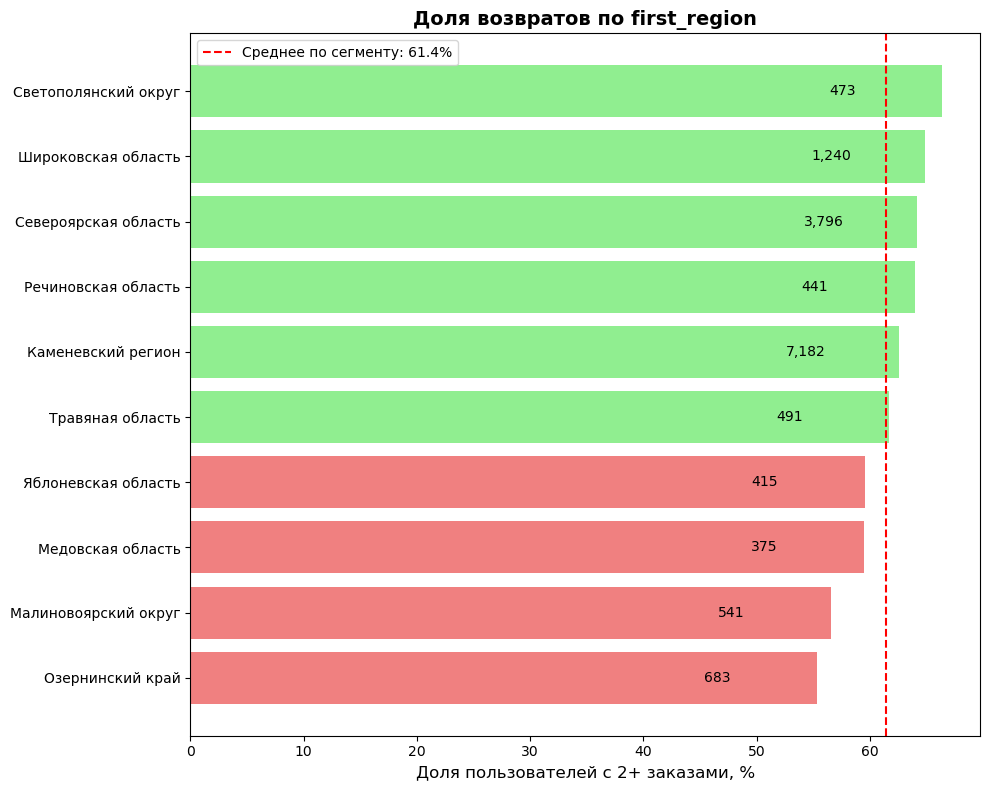

In [45]:
region_retention = analyze_segment_retention('first_region', top_n=10)


Топ-10 по first_service пользователей c 2 и более заказами:
---------------------------------------------


,first_service,total_users,retention_rate_pct
3,Билеты без проблем,5197,60.59
19,Лови билет!,2845,61.37
22,Мой билет,2671,59.04
4,Билеты в руки,2569,63.02
23,Облачко,2203,61.69
7,Весь в билетах,1313,63.29
20,Лучшие билеты,1187,61.42
24,Прачечная,594,62.96
17,Край билетов,458,65.28
12,Дом культуры,356,64.89


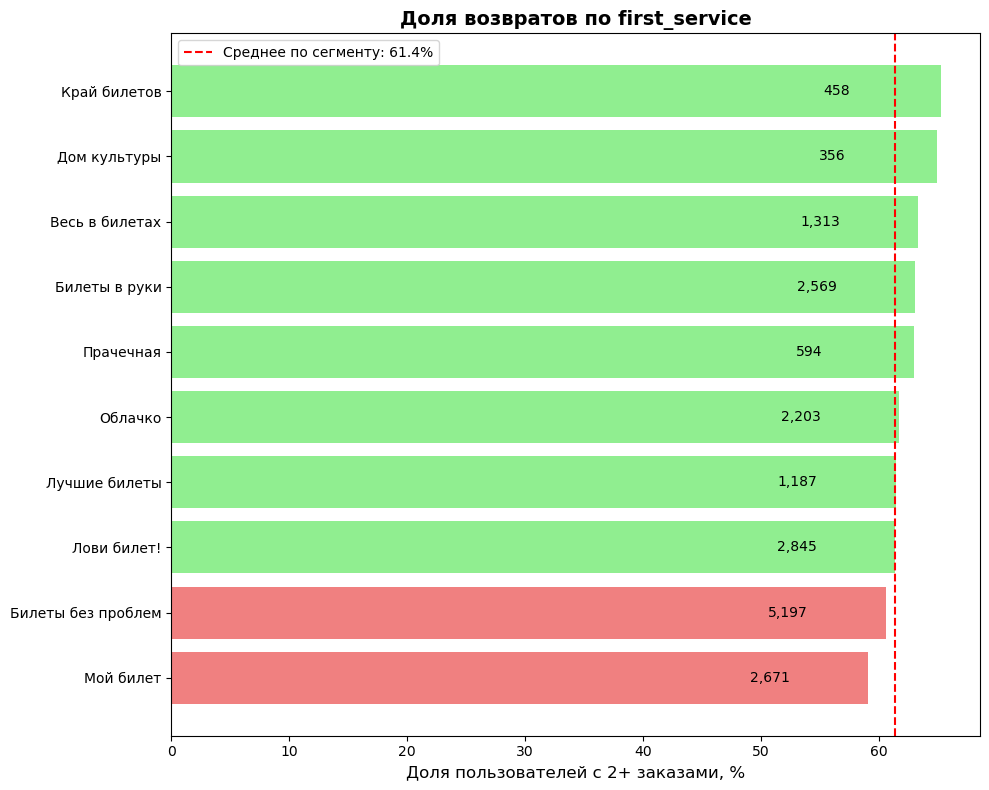

In [46]:
service_retention = analyze_segment_retention('first_service', top_n=10)

🎯 ВСЕ УСПЕШНЫЕ ТОЧКИ ВХОДА (для сегментов и чисденостью более 1000 человек):

In [47]:
segments = [
    ("Типы мероприятий", event_retention),
    ("Типы устройств", device_retention), 
    ("Регионы", region_retention),
    ("Билетные операторы", service_retention)
]

for segment_name, ret in segments:
    print(f'УСПЕШНЫЕ ТОЧКИ ВХОДА: {segment_name}')
    if len(ret) > 0:
        display(ret)
    else:
        print("   Нет успешных точек входа")
    print()

УСПЕШНЫЕ ТОЧКИ ВХОДА: Типы мероприятий


,first_event_type,total_users,retention_rate,retention_rate_pct
2,концерты,9291,0.62,61.75
5,театр,4301,0.64,63.66



УСПЕШНЫЕ ТОЧКИ ВХОДА: Типы устройств


,first_device,total_users,retention_rate,retention_rate_pct
0,desktop,3674,0.64,63.58



УСПЕШНЫЕ ТОЧКИ ВХОДА: Регионы


,first_region,total_users,retention_rate,retention_rate_pct
23,Каменевский регион,7182,0.63,62.59
60,Североярская область,3796,0.64,64.12
77,Широковская область,1240,0.65,64.84



УСПЕШНЫЕ ТОЧКИ ВХОДА: Билетные операторы


,first_service,total_users,retention_rate,retention_rate_pct
19,Лови билет!,2845,0.61,61.37
4,Билеты в руки,2569,0.63,63.02
23,Облачко,2203,0.62,61.69
7,Весь в билетах,1313,0.63,63.29
20,Лучшие билеты,1187,0.61,61.42


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

📊 ГИПОТЕЗА 1: Тип мероприятия влияет на вероятность возврата"

In [48]:
# Сравним спортивные мероприятия и концерты
sport_retention = user_profile_clean[user_profile_clean['first_event_type'] == 'спорт']['is_two'].mean()
concert_retention = user_profile_clean[user_profile_clean['first_event_type'] == 'концерты']['is_two'].mean()

print(f"📈 Доли возвратов:")
print(f"   • Спортивные мероприятия: {sport_retention:.2%} ({user_profile_clean[user_profile_clean['first_event_type'] == 'спорт'].shape[0]:,} пользователей)")
print(f"   • Концерты: {concert_retention:.2%} ({user_profile_clean[user_profile_clean['first_event_type'] == 'концерты'].shape[0]:,} пользователей)")
print(f"   • Разница: {concert_retention - sport_retention:+.2%}")

print(f"\n🎯 ВЫВОД ПО ГИПОТЕЗЕ 1:")
if sport_retention > concert_retention:
    print("   ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Спортивные мероприятия действительно имеют более высокую долю возвратов")
else:
    print("   ❌ ГИПОТЕЗА ОПРОВЕРГНУТА: Концерты имеют более высокую долю возвратов, чем спортивные мероприятия")

📈 Доли возвратов:
   • Спортивные мероприятия: 55.90% (805 пользователей)
   • Концерты: 61.75% (9,291 пользователей)
   • Разница: +5.85%

🎯 ВЫВОД ПО ГИПОТЕЗЕ 1:
   ❌ ГИПОТЕЗА ОПРОВЕРГНУТА: Концерты имеют более высокую долю возвратов, чем спортивные мероприятия


📊 ГИПОТЕЗА 2: В активных регионах выше доля повторных заказов

In [49]:
# Анализируем топ-10 региона по количеству пользователей
top_regions = user_profile_clean['first_region'].value_counts().head(10)
print("🎯 Топ-10 регионов по количеству пользователей:")
for region, count in top_regions.items():
    retention = user_profile_clean[user_profile_clean['first_region'] == region]['is_two'].mean()
    print(f"   • {region}: {count:,} пользователей, {retention:.2%} возвратов")

# Сравниваем с остальными регионами
top_regions_retention = user_profile_clean[user_profile_clean['first_region'].isin(top_regions.index)]['is_two'].mean()
other_regions_retention = user_profile_clean[~user_profile_clean['first_region'].isin(top_regions.index)]['is_two'].mean()

print(f"\n📈 Сравнение регионов:")
print(f"   • Топ-10 регионов: {top_regions_retention:.2%} возвратов")
print(f"   • Остальные регионы: {other_regions_retention:.2%} возвратов")
print(f"   • Разница: {top_regions_retention - other_regions_retention:+.2%}")

print(f"\n🎯 ВЫВОД ПО ГИПОТЕЗЕ 2:")
if top_regions_retention > other_regions_retention:
    print("   ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА: В наиболее активных регионах действительно выше доля повторных заказов")
else:
    print("   ❌ ГИПОТЕЗА ОПРОВЕРГНУТА: В наиболее активных регионах НЕТ более высокой доли возвратов")

🎯 Топ-10 регионов по количеству пользователей:
   • Каменевский регион: 7,182 пользователей, 62.59% возвратов
   • Североярская область: 3,796 пользователей, 64.12% возвратов
   • Широковская область: 1,240 пользователей, 64.84% возвратов
   • Озернинский край: 683 пользователей, 55.34% возвратов
   • Малиновоярский округ: 541 пользователей, 56.56% возвратов
   • Травяная область: 491 пользователей, 61.71% возвратов
   • Светополянский округ: 473 пользователей, 66.38% возвратов
   • Речиновская область: 441 пользователей, 63.95% возвратов
   • Яблоневская область: 415 пользователей, 59.52% возвратов
   • Медовская область: 375 пользователей, 59.47% возвратов

📈 Сравнение регионов:
   • Топ-10 регионов: 62.58% возвратов
   • Остальные регионы: 58.12% возвратов
   • Разница: +4.47%

🎯 ВЫВОД ПО ГИПОТЕЗЕ 2:
   ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА: В наиболее активных регионах действительно выше доля повторных заказов


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


📊 АНАЛИЗ СВЯЗИ ВЫРУЧКИ И ПОВТОРНЫХ ЗАКАЗОВ:

In [50]:
# Разделяем пользователей на группы
single_order_users = user_profile_clean[user_profile_clean['total_orders'] == 1]
multiple_order_users = user_profile_clean[user_profile_clean['total_orders'] >= 2]

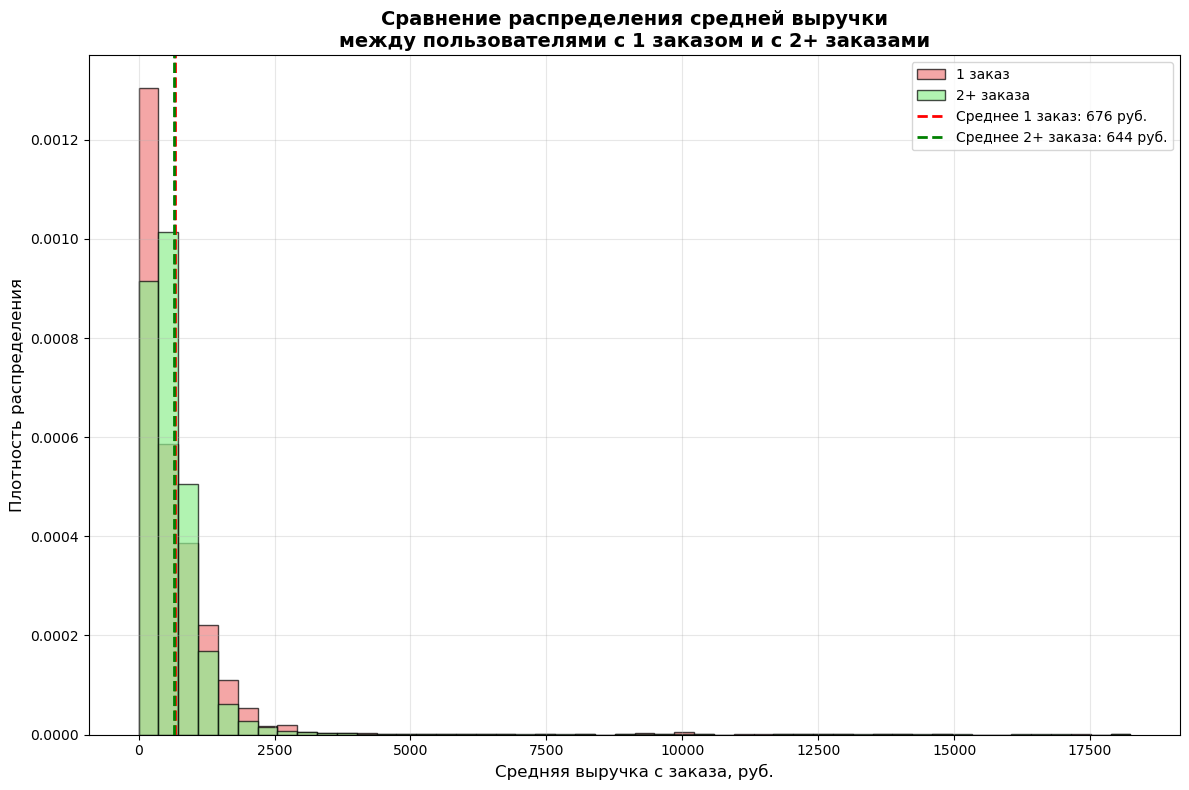

In [51]:
# Сравнительные гистограммы
plt.figure(figsize=(12, 8))


plt.hist(single_order_users['avg_revenue_rub'], 
         bins=50, alpha=0.7, color='lightcoral', 
         label='1 заказ', density=True, edgecolor='black')

plt.hist(multiple_order_users['avg_revenue_rub'], 
         bins=50, alpha=0.7, color='lightgreen', 
         label='2+ заказа', density=True, edgecolor='black')

plt.xlabel('Средняя выручка с заказа, руб.', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.title('Сравнение распределения средней выручки\nмежду пользователями с 1 заказом и с 2+ заказами', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# линии для средних значений
plt.axvline(single_order_users['avg_revenue_rub'].mean(), 
            color='red', linestyle='--', linewidth=2, 
            label=f'Среднее 1 заказ: {single_order_users["avg_revenue_rub"].mean():.0f} руб.')
plt.axvline(multiple_order_users['avg_revenue_rub'].mean(), 
            color='green', linestyle='--', linewidth=2, 
            label=f'Среднее 2+ заказа: {multiple_order_users["avg_revenue_rub"].mean():.0f} руб.')

plt.legend()
plt.tight_layout()
plt.show()

In [52]:
print(f"📈 РАЗМЕРЫ ГРУПП:")
print(f"   • Пользователи с 1 заказом: {len(single_order_users):,} чел.")
print(f"   • Пользователи с 2+ заказами: {len(multiple_order_users):,} чел.")

📈 РАЗМЕРЫ ГРУПП:
   • Пользователи с 1 заказом: 8,307 чел.
   • Пользователи с 2+ заказами: 13,194 чел.


In [53]:
print(f"\n📊 СТАТИСТИКИ ВЫРУЧКИ ПО ГРУППАМ:n")
print("Пользователи с 1 заказом:")
print(single_order_users['avg_revenue_rub'].describe())
print("\nПользователи с 2+ заказами:")
print(multiple_order_users['avg_revenue_rub'].describe())


📊 СТАТИСТИКИ ВЫРУЧКИ ПО ГРУППАМ:n
Пользователи с 1 заказом:
count    8307.00
mean      675.62
std      1206.82
min         0.00
25%       142.10
50%       398.41
75%       872.45
max     18241.24
Name: avg_revenue_rub, dtype: float64

Пользователи с 2+ заказами:
count   13194.00
mean      644.32
std       837.45
min         0.00
25%       285.30
50%       516.10
75%       793.85
max     18241.24
Name: avg_revenue_rub, dtype: float64


In [54]:
# Анализ концентрации пользователей по диапазонам выручки
def analyze_revenue_segments(users, group_name):
    print(f"\n📊 ДИАПАЗОНЫ ВЫРУЧКИ ДЛЯ {group_name}:")
    ranges = [
        (0, 1000, "0-1000 руб."),
        (1000, 2000, "1000-2000 руб."),
        (2000, 3000, "2000-3000 руб."),
        (3000, float('inf'), "3000+ руб.")
    ]
    
    for min_val, max_val, label in ranges:
        if max_val == float('inf'):
            count = len(users[users['avg_revenue_rub'] >= min_val])
        else:
            count = len(users[(users['avg_revenue_rub'] >= min_val) & (users['avg_revenue_rub'] < max_val)])
        percentage = (count / len(users)) * 100
        print(f"   • {label}: {count:,} пользователей ({percentage:.1f}%)")

In [55]:
analyze_revenue_segments(single_order_users, "пользователи с 1 заказом")

analyze_revenue_segments(multiple_order_users, "пользователи с 2+ заказами")


📊 ДИАПАЗОНЫ ВЫРУЧКИ ДЛЯ пользователи с 1 заказом:
   • 0-1000 руб.: 6,627 пользователей (79.8%)
   • 1000-2000 руб.: 1,362 пользователей (16.4%)
   • 2000-3000 руб.: 189 пользователей (2.3%)
   • 3000+ руб.: 129 пользователей (1.6%)

📊 ДИАПАЗОНЫ ВЫРУЧКИ ДЛЯ пользователи с 2+ заказами:
   • 0-1000 руб.: 11,279 пользователей (85.5%)
   • 1000-2000 руб.: 1,615 пользователей (12.2%)
   • 2000-3000 руб.: 174 пользователей (1.3%)
   • 3000+ руб.: 126 пользователей (1.0%)


1. В каких диапазонах средней выручки концентрируются пользователи из каждой группы?  

- Обе группы концентрируются в 0-1000 руб. (79.8% и 85.5%)
- Минимальная доля в высоких ценовых сегментах

2. Есть ли различия между группами?  
   Да. Пользователей с 2+ заказами БОЛЬШЕ в низком ценовом сегменте (+5.7%) и МЕНЬШЕ во всех более высоких сегментах

`ВЫВОД`: Лояльные пользователи чаще делают недорогие заказы.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [56]:
# Разделяем пользователей на группы по активности
users_2_4_orders = user_profile_clean[
    (user_profile_clean['total_orders'] >= 2) & 
    (user_profile_clean['total_orders'] <= 4)
]
users_5_plus_orders = user_profile_clean[user_profile_clean['total_orders'] >= 5]

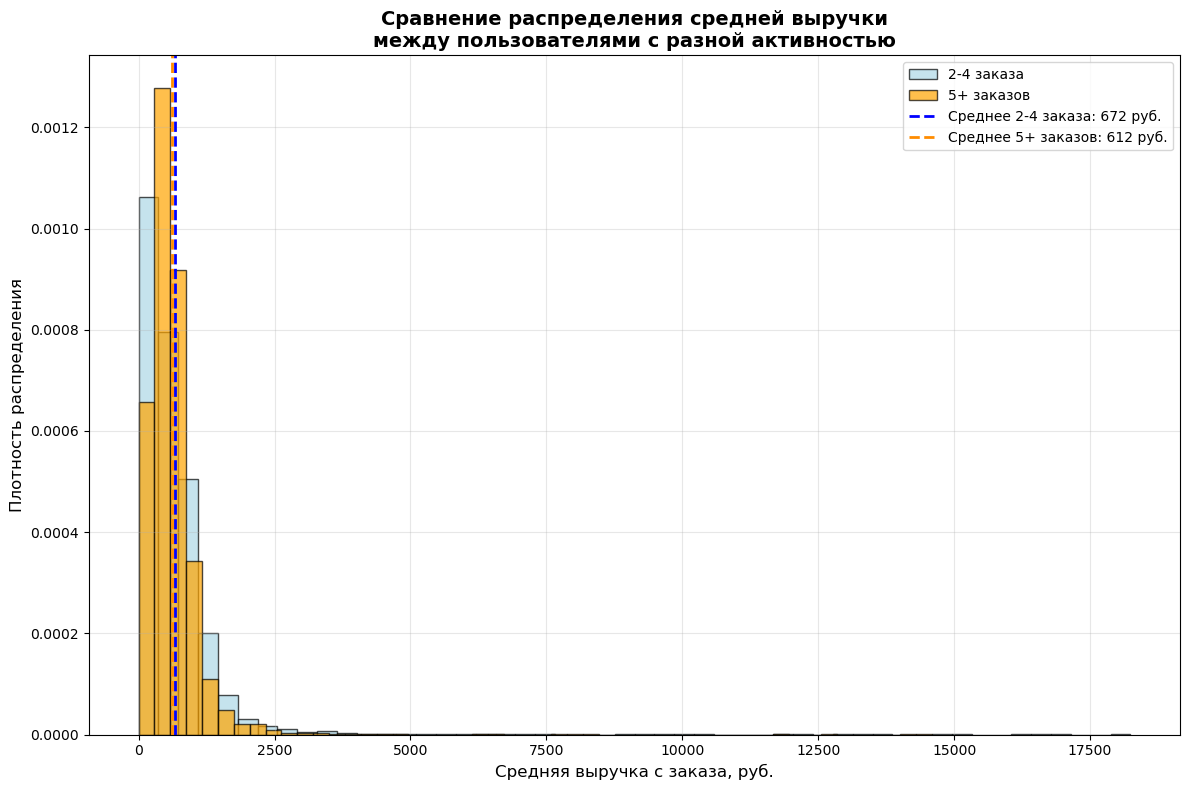

In [57]:
# Сравнительные гистограммы
plt.figure(figsize=(12, 8))

plt.hist(users_2_4_orders['avg_revenue_rub'], 
         bins=50, alpha=0.7, color='lightblue', 
         label='2-4 заказа', density=True, edgecolor='black')

plt.hist(users_5_plus_orders['avg_revenue_rub'], 
         bins=50, alpha=0.7, color='orange', 
         label='5+ заказов', density=True, edgecolor='black')

plt.xlabel('Средняя выручка с заказа, руб.', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.title('Сравнение распределения средней выручки\nмежду пользователями с разной активностью', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# линии для средних значений
plt.axvline(users_2_4_orders['avg_revenue_rub'].mean(), 
            color='blue', linestyle='--', linewidth=2, 
            label=f'Среднее 2-4 заказа: {users_2_4_orders["avg_revenue_rub"].mean():.0f} руб.')
plt.axvline(users_5_plus_orders['avg_revenue_rub'].mean(), 
            color='darkorange', linestyle='--', linewidth=2, 
            label=f'Среднее 5+ заказов: {users_5_plus_orders["avg_revenue_rub"].mean():.0f} руб.')

plt.legend()
plt.tight_layout()
plt.show()

In [58]:
print(f"📈 РАЗМЕРЫ ГРУПП:")
print(f"   • Пользователи с 2-4 заказами: {len(users_2_4_orders):,} чел.")
print(f"   • Пользователи с 5+ заказами: {len(users_5_plus_orders):,} чел.")

📈 РАЗМЕРЫ ГРУПП:
   • Пользователи с 2-4 заказами: 7,088 чел.
   • Пользователи с 5+ заказами: 6,106 чел.


In [59]:
print(f"\n📊 СТАТИСТИКИ ВЫРУЧКИ ПО ГРУППАМ:")
print("Пользователи с 2-4 заказами:")
print(users_2_4_orders['avg_revenue_rub'].describe())
print("\nПользователи с 5+ заказами:")
print(users_5_plus_orders['avg_revenue_rub'].describe())


📊 СТАТИСТИКИ ВЫРУЧКИ ПО ГРУППАМ:
Пользователи с 2-4 заказами:
count    7088.00
mean      672.32
std      1012.69
min         0.00
25%       231.99
50%       491.40
75%       840.33
max     18241.24
Name: avg_revenue_rub, dtype: float64

Пользователи с 5+ заказами:
count    6106.00
mean      611.80
std       568.42
min         0.00
25%       345.79
50%       532.96
75%       748.57
max     14592.98
Name: avg_revenue_rub, dtype: float64


In [60]:
analyze_revenue_segments(users_2_4_orders, "пользователей с 2-4 заказами")

analyze_revenue_segments(users_5_plus_orders, "пользователей с 5+ заказами")


📊 ДИАПАЗОНЫ ВЫРУЧКИ ДЛЯ пользователей с 2-4 заказами:
   • 0-1000 руб.: 5,853 пользователей (82.6%)
   • 1000-2000 руб.: 1,033 пользователей (14.6%)
   • 2000-3000 руб.: 105 пользователей (1.5%)
   • 3000+ руб.: 97 пользователей (1.4%)

📊 ДИАПАЗОНЫ ВЫРУЧКИ ДЛЯ пользователей с 5+ заказами:
   • 0-1000 руб.: 5,426 пользователей (88.9%)
   • 1000-2000 руб.: 582 пользователей (9.5%)
   • 2000-3000 руб.: 69 пользователей (1.1%)
   • 3000+ руб.: 29 пользователей (0.5%)


Пользователи с 5+ заказами имеют более низкую среднюю выручку с заказа:

- 2-4 заказа: 672 руб.
- 5+ заказов: 612 руб.

  Разница: -60 руб. (-8.9%)


Более лояльные пользователи (5+ заказов) в низком ценовом сегменте (88.9% vs 82.6%)

У них меньше пользователей в среднем и высоком ценовых сегментах

Медианная выручка однако выше у более активных пользователей (532.96 vs 491.40)

`Вывод`: Самые лояльные пользователи склонны делать более частые, но менее дорогие покупки.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [61]:
print(f"\n📈 ОБЩАЯ СТАТИСТИКА ПО БИЛЕТАМ:")
user_profile_clean['avg_tickets_count'].describe()


📈 ОБЩАЯ СТАТИСТИКА ПО БИЛЕТАМ:


count   21501.00
mean        2.53
std         0.97
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        12.00
Name: avg_tickets_count, dtype: float64

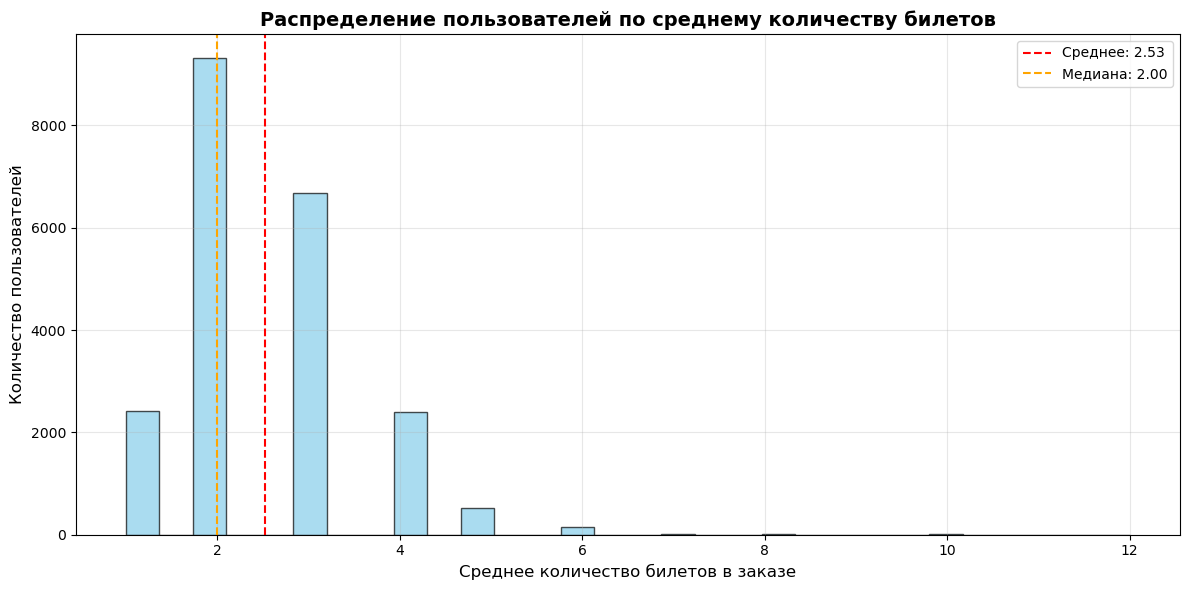

In [62]:
# распределение количества билетов
plt.figure(figsize=(12, 6))
plt.hist(user_profile_clean['avg_tickets_count'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Среднее количество билетов в заказе', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение пользователей по среднему количеству билетов', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.axvline(user_profile_clean['avg_tickets_count'].mean(), color='red', linestyle='--', 
           label=f'Среднее: {user_profile_clean["avg_tickets_count"].mean():.2f}')
plt.axvline(user_profile_clean['avg_tickets_count'].median(), color='orange', linestyle='--', 
           label=f'Медиана: {user_profile_clean["avg_tickets_count"].median():.2f}')

plt.legend()
plt.tight_layout()
plt.show()

In [63]:
print(f"\n🔍 СЕГМЕНТАЦИЯ ПО КОЛИЧЕСТВУ БИЛЕТОВ:")
print("=" * 60)

# Определяем сегменты
segments = [
    (1, 2, "1-2 билета"),
    (2, 3, "2-3 билета"), 
    (3, 5, "3-5 билетов"),
    (5, 7, "5-7 билетов"),
    (7, float('inf'), "7+ билетов")
]

segment_stats = []

print(f"{'segment':<15} | {'total_users':<12} | {'segment_share':<8} | {'retention':<10}")
print("-" * 60)

for min_tickets, max_tickets, segment_name in segments:
    if max_tickets == float('inf'):
        segment_users = user_profile_clean[user_profile_clean['avg_tickets_count'] >= min_tickets]
    else:
        segment_users = user_profile_clean[(user_profile_clean['avg_tickets_count'] >= min_tickets) & 
                                         (user_profile_clean['avg_tickets_count'] < max_tickets)]
    
    total_users = len(segment_users)
    retention = segment_users['is_two'].mean()
    segment_share = (total_users / len(user_profile_clean)) * 100
    
    segment_stats.append({
        'segment': segment_name,
        'total_users': total_users,
        'segment_share': segment_share,
        'retention': retention
    })
    
    print(f"{segment_name:<15} | {total_users:>12,} | {segment_share:>12.1f}% | {retention:>9.2%}")


🔍 СЕГМЕНТАЦИЯ ПО КОЛИЧЕСТВУ БИЛЕТОВ:
segment         | total_users  | segment_share | retention 
------------------------------------------------------------
1-2 билета      |        2,418 |         11.2% |    50.87%
2-3 билета      |        9,324 |         43.4% |    73.44%
3-5 билетов     |        9,071 |         42.2% |    54.93%
5-7 билетов     |          676 |          3.1% |    19.08%
7+ билетов      |           12 |          0.1% |    33.33%


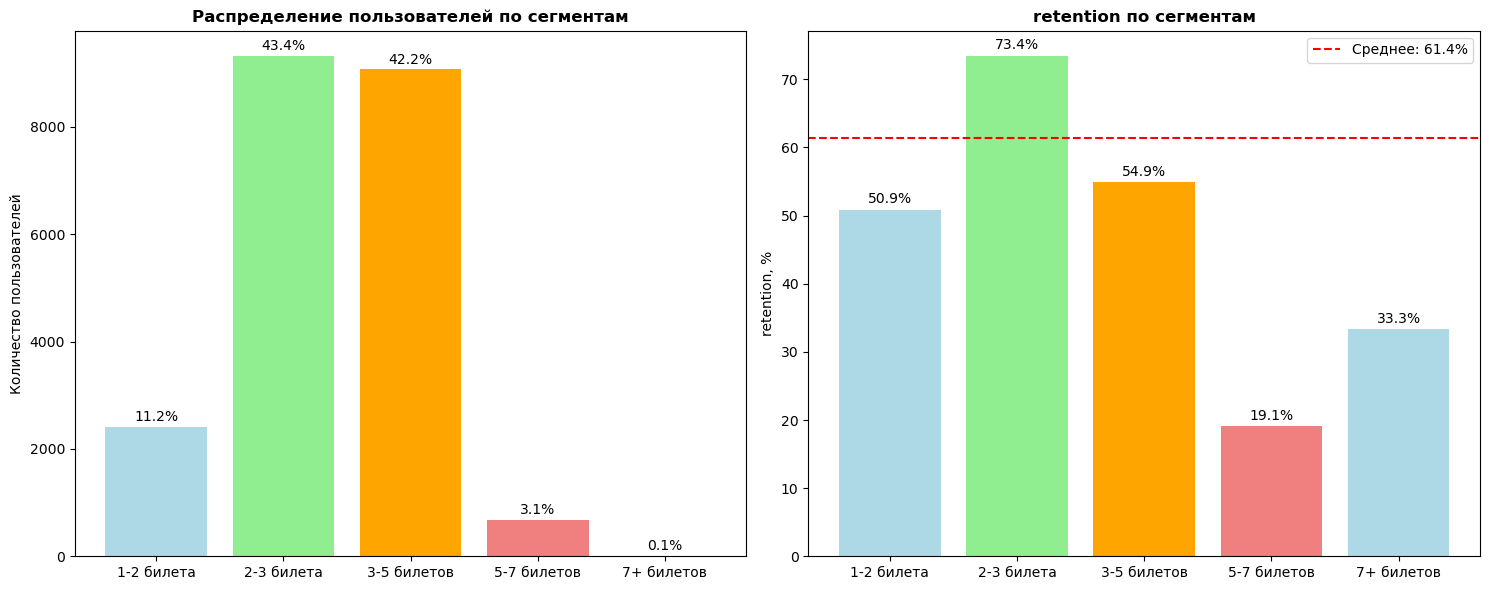

In [64]:
# Сравнительные графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Распределение пользователей по сегментам
segments_names = [stat['segment'] for stat in segment_stats]
users_counts = [stat['total_users'] for stat in segment_stats]

bars1 = ax1.bar(segments_names, users_counts, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
ax1.set_title('Распределение пользователей по сегментам', fontweight='bold')
ax1.set_ylabel('Количество пользователей')
ax1.tick_params(axis='x')

# подписи с процентами
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{segment_stats[i]["segment_share"]:.1f}%', ha='center', va='bottom')

# Доля возвратов по сегментам
retention_rates = [stat['retention'] * 100 for stat in segment_stats]

bars2 = ax2.bar(segments_names, retention_rates, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
ax2.set_title('retention по сегментам', fontweight='bold')
ax2.set_ylabel('retention, %')

ax2.axhline(overall_retention * 100, color='red', linestyle='--', 
           label=f'Среднее: {overall_retention:.1%}')
ax2.tick_params(axis='x')
ax2.legend()

# подписи с значениями
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{retention_rates[i]:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

`Выводы:`

1. Распределение НЕ равномерное - пользователи сконцентрированы в сегментах "2-3 билета" (43.4%) и "3-5 билетов" (42.2%)
2. есть аномальные сегменты:
- Высокая доля возвратов: "2-3 билета" - 73.44% (на +12.08% выше среднего)
- Низкая доля возвратов: "7+ билетов" - 0.1% (на -42.03% ниже среднего)

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [65]:
user_profile_clean

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3,75.00,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2,51.00,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1,16.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21714,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,688.04,2,13.38,1,1
21715,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,851.00,2,74.00,1,0
21716,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,33,557.91,2,4.12,1,1
21717,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.53,2,NaN,0,0


In [66]:
user_profile_weekday = user_profile_clean.copy()

# День недели первой покупки
user_profile_weekday['first_order_weekday'] = user_profile_weekday['first_order_dt'].dt.day_name()

In [67]:
# Порядок дней недели для корректного отображения
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

user_profile_weekday['first_order_weekday'] = pd.Categorical(
    user_profile_weekday['first_order_weekday'], 
    categories=weekday_order, 
    ordered=True
)

# распределение пользователей по дням недели первой покупки
weekday_analysis = user_profile_weekday.groupby('first_order_weekday').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'total_orders': 'mean',
    'avg_revenue_rub': 'mean',
    'avg_tickets_count': 'mean'
}).rename(columns={
    'user_id': 'total_users',
    'is_two': 'retention'
}).reset_index()

weekday_analysis['user_share'] = (weekday_analysis['total_users'] / len(user_profile_weekday)) * 100

print("📊 РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ДНЯМ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ")
print("=" * 75)
print(f"{'day_of_week':<12} | {'total_users':<12} | {'users_share':<5} | {'retention':<12} |{'avg_tickets_count':<10}")
print("-" * 75)

for _, row in weekday_analysis.iterrows():
    print(f"{row['first_order_weekday']:<12} | {row['total_users']:>12,} | {row['user_share']:>9.1f}% | {row['retention']:>13.2%} | {row['total_orders']:>10.2f}")

print(f"\nСредний retention 2+ заказов: {overall_retention:.2%}")

📊 РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ДНЯМ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ
day_of_week  | total_users  | users_share | retention    |avg_tickets_count
---------------------------------------------------------------------------
Monday       |        2,872 |      13.4% |        63.09% |       6.65
Tuesday      |        3,083 |      14.3% |        61.60% |       6.84
Wednesday    |        3,034 |      14.1% |        62.03% |       5.85
Thursday     |        3,119 |      14.5% |        59.89% |       5.46
Friday       |        3,277 |      15.2% |        59.99% |       5.46
Saturday     |        3,327 |      15.5% |        62.70% |       8.16
Sunday       |        2,789 |      13.0% |        60.27% |       7.08

Средний retention 2+ заказов: 61.36%


C:\Users\max\AppData\Local\Temp\ipykernel_15044\269422595.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_analysis = user_profile_weekday.groupby('first_order_weekday').agg({


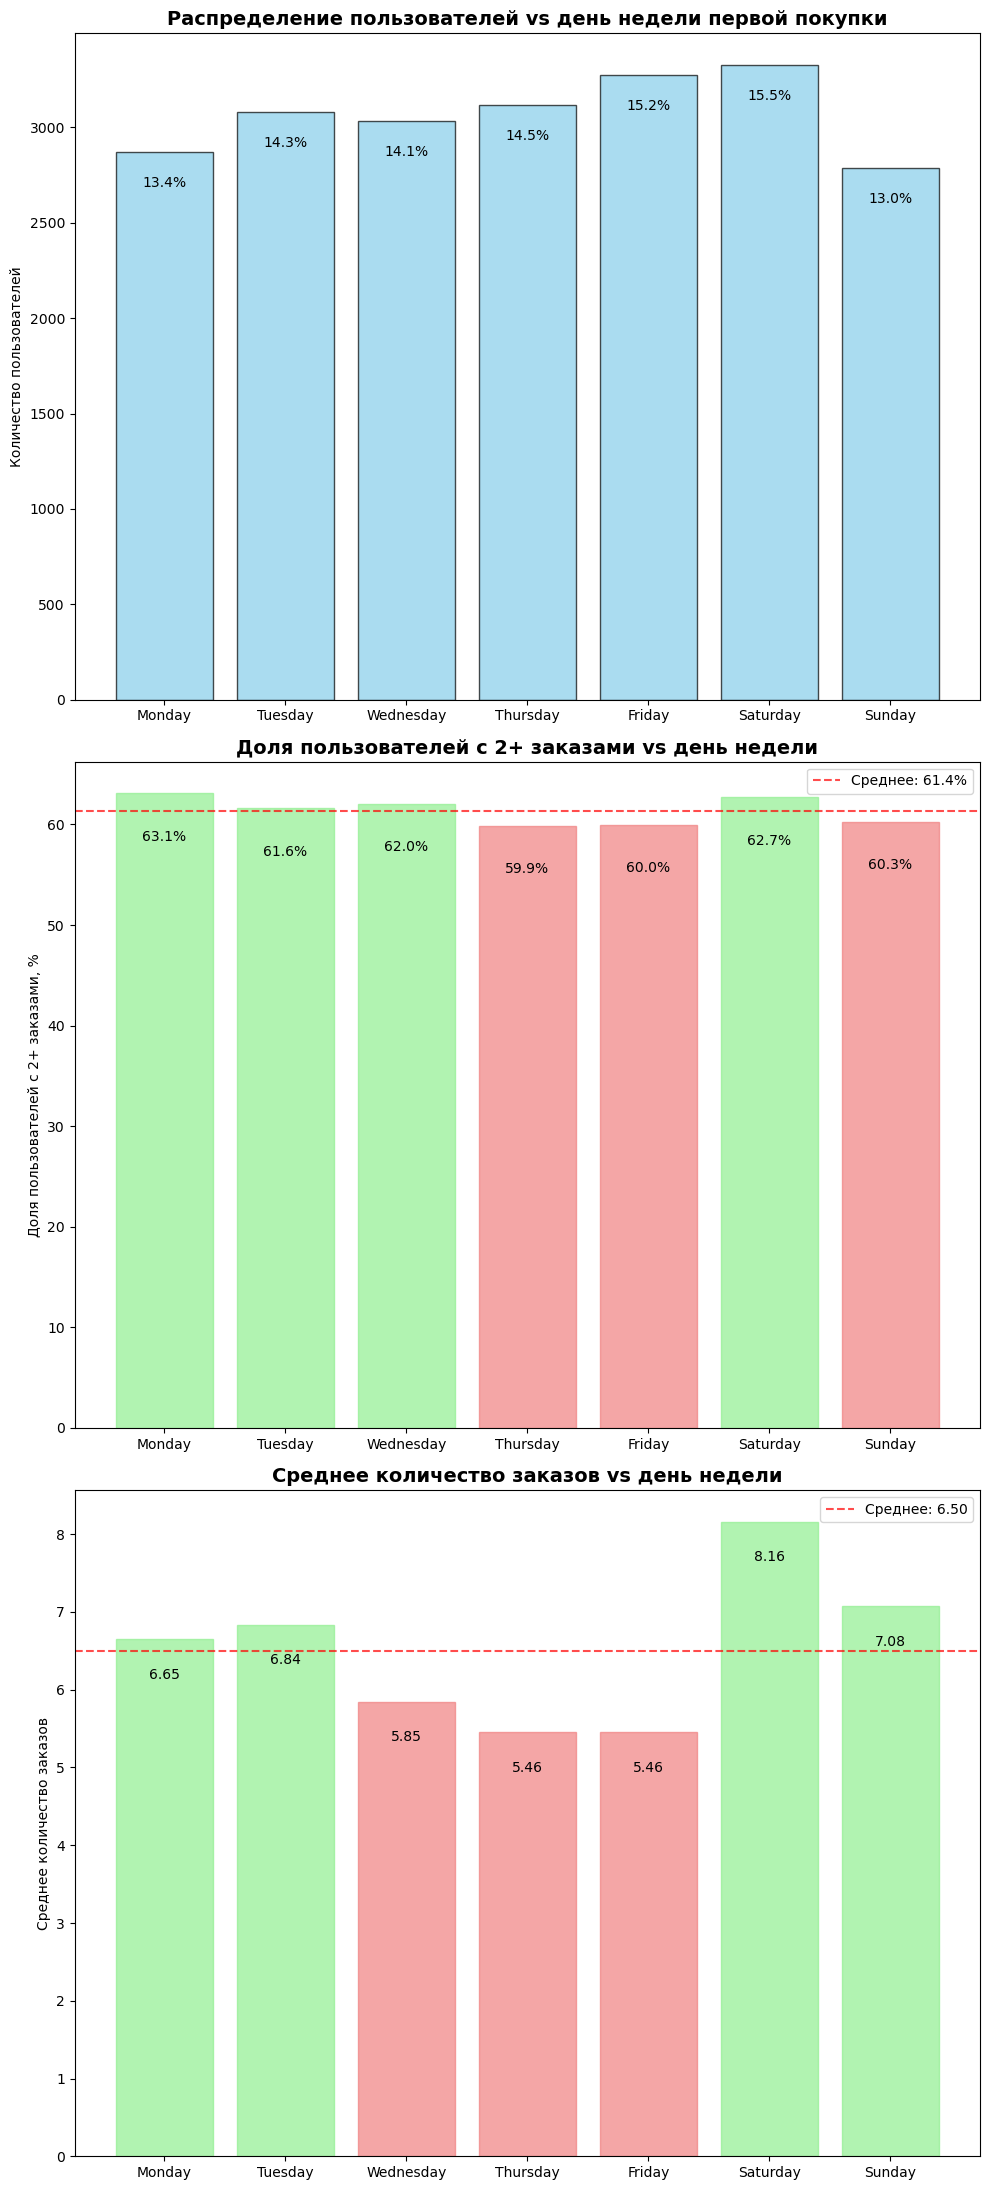

In [68]:
fig, axes = plt.subplots(3, 1, figsize=(10, 22))

# 1. Распределение пользователей по дням недели
axes[0].bar(weekday_analysis['first_order_weekday'], weekday_analysis['total_users'], 
           color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение пользователей vs день недели первой покупки', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество пользователей')
axes[0].tick_params(axis='x')

# Подписи с процентами
for i, v in enumerate(weekday_analysis['total_users']):
    axes[0].text(i, v - 200, f'{weekday_analysis["user_share"].iloc[i]:.1f}%', 
                ha='center', va='bottom', fontsize=10)

# 2. Доля пользователей с 2+ заказами по дням недели
bars = axes[1].bar(weekday_analysis['first_order_weekday'], weekday_analysis['retention'] * 100,
                  color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_title('Доля пользователей с 2+ заказами vs день недели', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Доля пользователей с 2+ заказами, %')

axes[1].axhline(overall_retention * 100, color='red', linestyle='--', alpha=0.7,
               label=f'Среднее: {overall_retention:.1%}')
axes[1].tick_params(axis='x')
axes[1].legend()

# столбцы выше среднего в зеленый, ниже - в оранжевый
for i, bar in enumerate(bars):
    if weekday_analysis['retention'].iloc[i] > overall_retention:
        bar.set_color('lightgreen')
    else:
        bar.set_color('lightcoral')

# Подписи с значениями
for i, v in enumerate(weekday_analysis['retention'] * 100):
    axes[1].text(i, v - 5, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# 3. Среднее количество заказов по дням недели
bars = axes[2].bar(weekday_analysis['first_order_weekday'], weekday_analysis['total_orders'],
                  color='lightblue', edgecolor='black', alpha=0.7)
axes[2].set_title('Среднее количество заказов vs день недели', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Среднее количество заказов')
mean_orders = user_profile_weekday['total_orders'].mean()
axes[2].axhline(mean_orders, color='red', linestyle='--', alpha=0.7,
               label=f'Среднее: {mean_orders:.2f}')
axes[2].tick_params(axis='x')
axes[2].legend()

# столбцы выше среднего в зеленый, ниже - в оранжевый
for i, bar in enumerate(bars):
    if weekday_analysis['total_orders'].iloc[i] > mean_orders:
        bar.set_color('lightgreen')
    else:
        bar.set_color('lightcoral')

# Подписи с значениями
for i, v in enumerate(weekday_analysis['total_orders']):
    axes[2].text(i, v - 0.55, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

`Вывод:` 

1. Влияет ли день недели на вероятность возврата?
   ДА, день недели первой покупки ВЛИЯЕТ на вероятность возврата клиента.

    Наименее благоприятные дни:
    - Четверг - 59.89% retention (-1.47% ниже среднего)
    - Пятница - 59.99% retention (-1.37% ниже среднего)
    - Воскресенье - 60.03%

2. Распределение пользователей относительно равномерное (13.0%-15.5%), без явных пиков

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [69]:
# пользователи с 2+ заказами (у них есть данные о времени между заказами)
users_with_intervals = user_profile_clean[user_profile_clean['avg_days_between_orders'].notna()].copy()

print("📊 ОБЩАЯ СТАТИСТИКА ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ")
print("=" * 60)
print(f"Всего пользователей с данными о интервалах: {len(users_with_intervals):,}")
print(f"Из них с 2-4 заказами: {len(users_with_intervals[users_with_intervals['total_orders'].between(2, 4)]):,}")
print(f"С 5+ заказами: {len(users_with_intervals[users_with_intervals['total_orders'] >= 5]):,}")

📊 ОБЩАЯ СТАТИСТИКА ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ
Всего пользователей с данными о интервалах: 13,244
Из них с 2-4 заказами: 7,088
С 5+ заказами: 6,106


In [70]:
# группы по активности
users_2_4 = users_with_intervals[users_with_intervals['total_orders'].between(2, 4)]
users_5_plus = users_with_intervals[users_with_intervals['total_orders'] >= 5]

In [71]:
# Базовая статистика по интервалам
print(f"\n📈 СТАТИСТИКА ИНТЕРВАЛОВ МЕЖДУ ЗАКАЗАМИ (2-4 заказа):")
users_2_4.avg_days_between_orders.describe()


📈 СТАТИСТИКА ИНТЕРВАЛОВ МЕЖДУ ЗАКАЗАМИ (2-4 заказа):


count   7088.00
mean      21.44
std       28.58
min        0.00
25%        0.00
50%        9.00
75%       34.00
max      148.00
Name: avg_days_between_orders, dtype: float64

In [72]:
# Базовая статистика по интервалам
print(f"\n📈 СТАТИСТИКА ИНТЕРВАЛОВ МЕЖДУ ЗАКАЗАМИ(5 и более):")
users_5_plus.avg_days_between_orders.describe()


📈 СТАТИСТИКА ИНТЕРВАЛОВ МЕЖДУ ЗАКАЗАМИ(5 и более):


count   6106.00
mean       9.95
std        7.82
min        0.00
25%        3.92
50%        8.20
75%       14.19
max       37.50
Name: avg_days_between_orders, dtype: float64

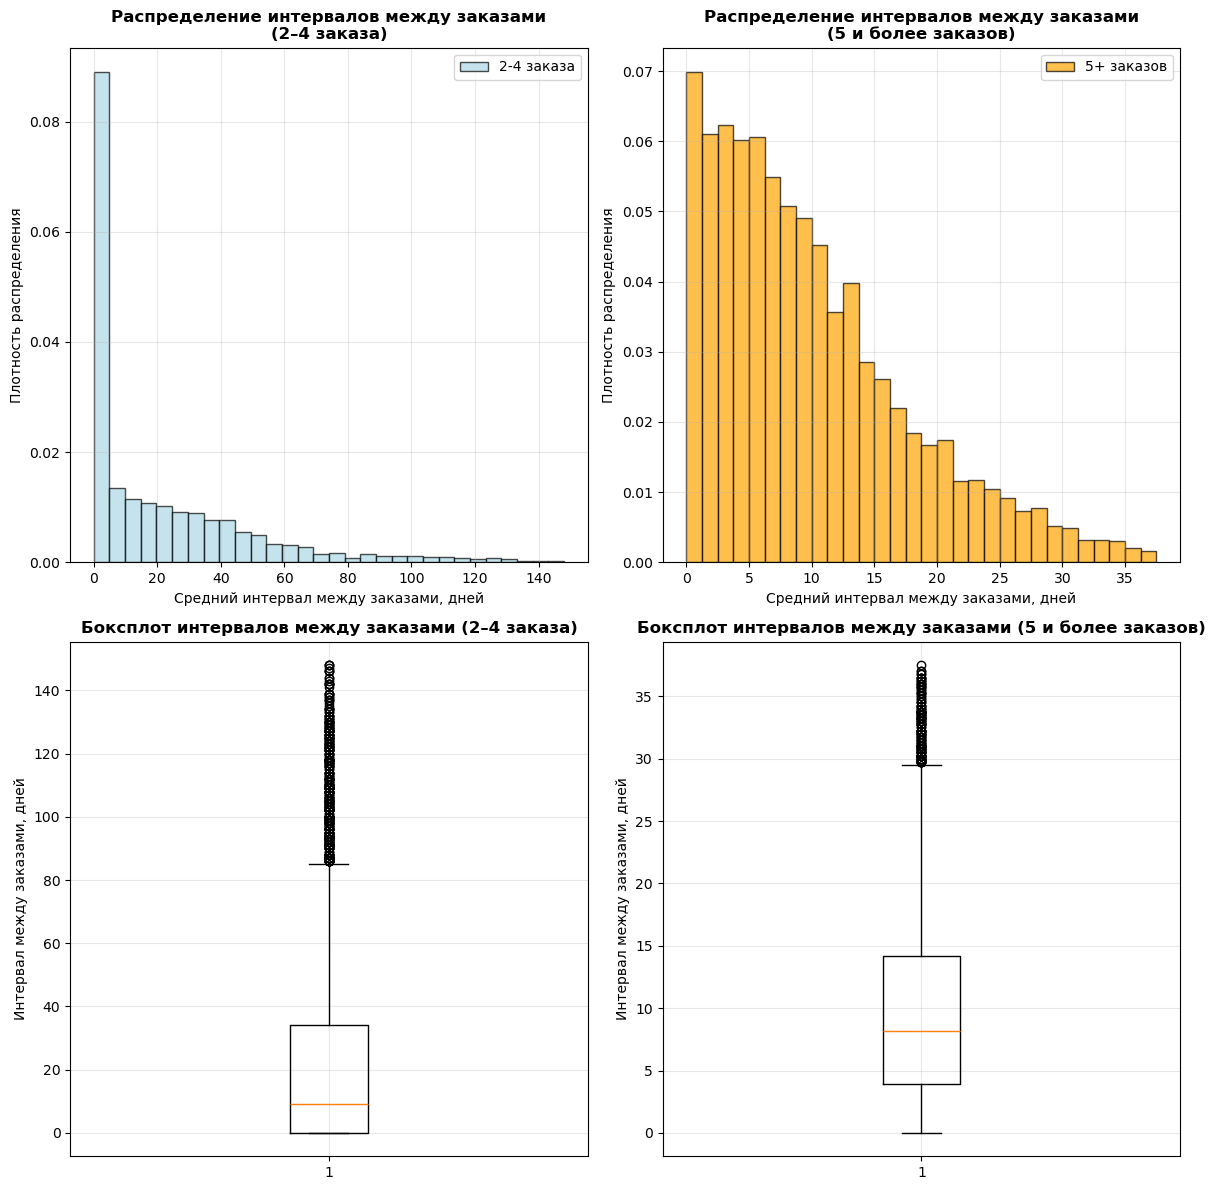

In [73]:
# Визуализация распределения интервалов между заказами
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Сравнительные гистограммы
axes[0,0].hist(users_2_4['avg_days_between_orders'], bins=30, alpha=0.7, 
               color='lightblue', label='2-4 заказа', density=True, edgecolor='black')

axes[0,0].set_xlabel('Средний интервал между заказами, дней')
axes[0,0].set_ylabel('Плотность распределения')
axes[0,0].set_title('Распределение интервалов между заказами\n(2–4 заказа)', fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(users_5_plus['avg_days_between_orders'], bins=30, alpha=0.7, 
               color='orange', label='5+ заказов', density=True, edgecolor='black')
axes[0,1].set_xlabel('Средний интервал между заказами, дней')
axes[0,1].set_ylabel('Плотность распределения')
axes[0,1].set_title('Распределение интервалов между заказами\n(5 и более заказов)', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 2. Боксплоты
axes[1,0].boxplot(users_2_4['avg_days_between_orders'])
axes[1,0].set_ylabel('Интервал между заказами, дней')
axes[1,0].set_title('Боксплот интервалов между заказами (2–4 заказа)', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].boxplot(users_5_plus['avg_days_between_orders'])
axes[1,1].set_ylabel('Интервал между заказами, дней')
axes[1,1].set_title('Боксплот интервалов между заказами (5 и более заказов)', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Существенная разница в интервалах:
- 2-4 заказа: 21.44 дня в среднем
- 5+ заказов: 9.95 дней в среднем
   
   Разница: 11.49 дней

2. Медианные значения еще более показательны:
- 2-4 заказа: 9 дней
- 5+ заказов: 8.2 дней

3. Разный разброс данных:
- Пользователи с 2-4 заказами имеют большой разброс интервалов (до 148 дней)
- Пользователи с 5+ заказами имеют более стабильные и короткие интервалы (максимум 37.5 дней)

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [74]:
correlation_data = user_profile_clean.copy()

In [75]:
# сегменты пользователей по количеству заказов
def define_order_segment(total_orders):
    if total_orders == 1:
        return '1 заказ'
    elif 2 <= total_orders <= 4:
        return '2-4 заказа'
    else:
        return '5+ заказов'

correlation_data['order_segment'] = correlation_data['total_orders'].apply(define_order_segment)

In [76]:
# признаки для анализа
features_for_correlation = [
    'first_device',
    'first_region', 
    'first_service',
    'first_event_type',
    'avg_revenue_rub',
    'avg_tickets_count',
    'order_segment'
]

correlation_df = correlation_data[features_for_correlation].copy()

phi_k_matrix = correlation_df.phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets_count'])

phi_k_matrix

,first_device,first_region,first_service,first_event_type,avg_revenue_rub,avg_tickets_count,order_segment
first_device,1.00,0.11,0.09,0.06,0.01,0.04,0.02
first_region,0.11,1.00,0.69,0.51,0.54,0.08,0.12
first_service,0.09,0.69,1.00,0.59,0.38,0.16,0.08
first_event_type,0.06,0.51,0.59,1.00,0.10,0.08,0.04
avg_revenue_rub,0.01,0.54,0.38,0.10,1.00,0.25,0.08
avg_tickets_count,0.04,0.08,0.16,0.08,0.25,1.00,0.33
order_segment,0.02,0.12,0.08,0.04,0.08,0.33,1.00


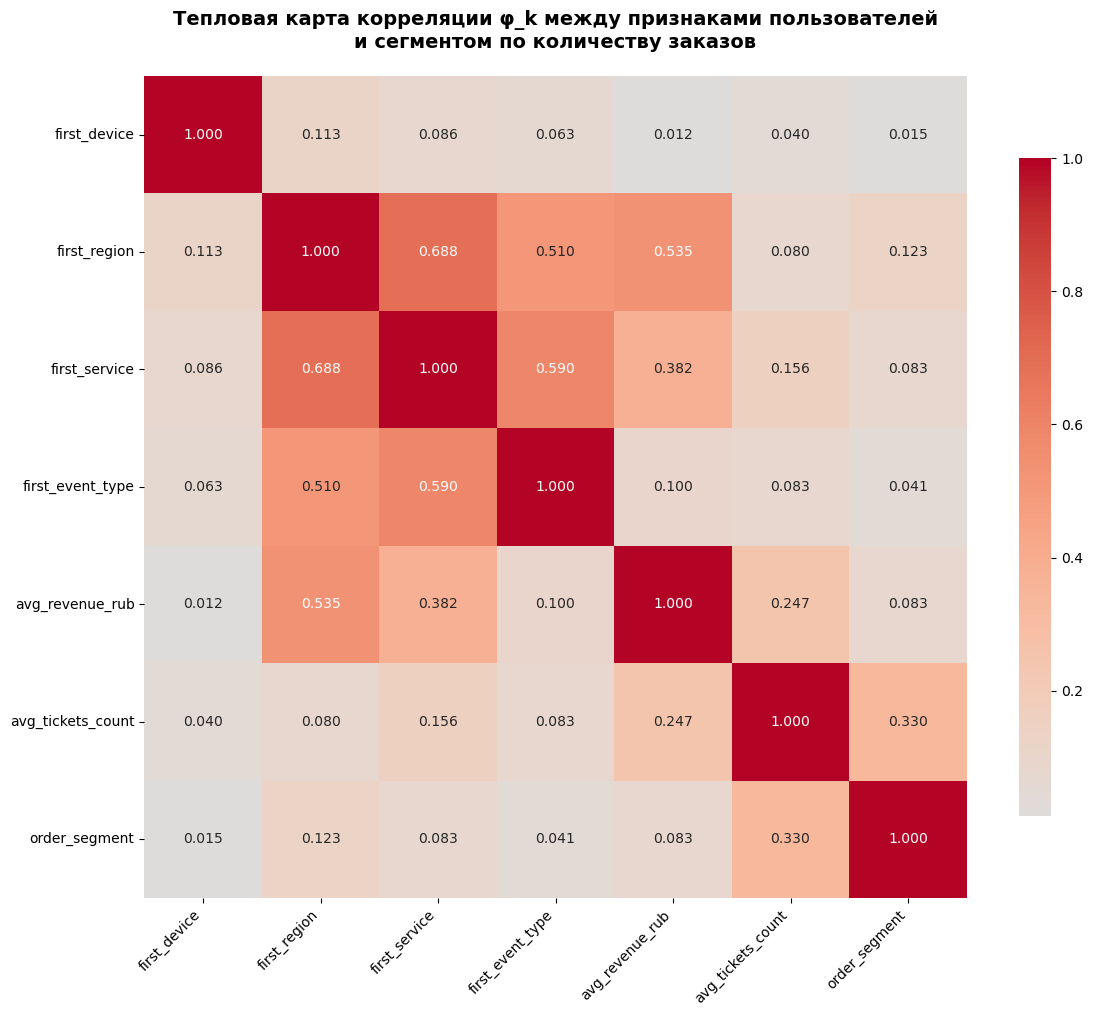

In [77]:
# Визуализация тепловой карты корреляции
plt.figure(figsize=(12, 10))

sns.heatmap(phi_k_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})

plt.title('Тепловая карта корреляции φ_k между признаками пользователей\nи сегментом по количеству заказов', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

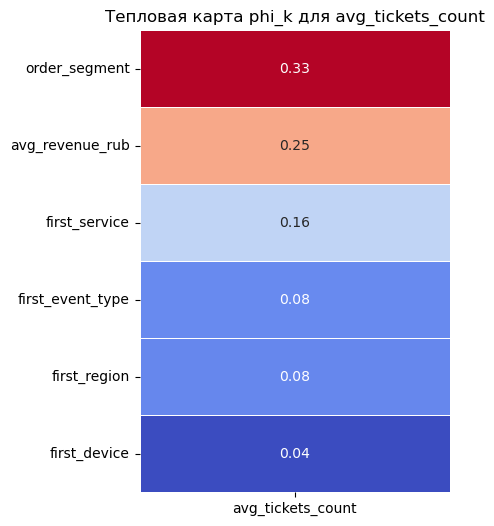

In [78]:
plt.figure(figsize=(4, 6))

data_heatmap = (phi_k_matrix
                .loc[phi_k_matrix.index != 'avg_tickets_count'][['avg_tickets_count']]
                .sort_values(by='avg_tickets_count', ascending=False))

sns.heatmap(data_heatmap,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=False)

plt.title('Тепловая карта phi_k для avg_tickets_count')

plt.show()

In [79]:
data_heatmap

,avg_tickets_count
order_segment,0.33
avg_revenue_rub,0.25
first_service,0.16
first_event_type,0.08
first_region,0.08
first_device,0.04


In [80]:
# Детальный анализ корреляции avg_tickets_count с другими признаками
print("📊 ДЕТАЛЬНЫЙ АНАЛИЗ КОРРЕЛЯЦИЙ ДЛЯ AVG_TICKETS_COUNT")
print("=" * 70)

print("Сила корреляции avg_tickets_count с другими признаками:")
print("-" * 50)
for index, value in data_heatmap.itertuples():
    strength = ""
    if value >= 0.5:
        strength = "🚀 СИЛЬНАЯ"
    elif value >= 0.3:
        strength = "📈 УМЕРЕННАЯ" 
    elif value >= 0.1:
        strength = "📊 СЛАБАЯ"
    else:
        strength = "📉 ОЧЕНЬ СЛАБАЯ"
    
    print(f"{index:<25} | φ_k = {value:.2f} | {strength}")

📊 ДЕТАЛЬНЫЙ АНАЛИЗ КОРРЕЛЯЦИЙ ДЛЯ AVG_TICKETS_COUNT
Сила корреляции avg_tickets_count с другими признаками:
--------------------------------------------------
order_segment             | φ_k = 0.33 | 📈 УМЕРЕННАЯ
avg_revenue_rub           | φ_k = 0.25 | 📊 СЛАБАЯ
first_service             | φ_k = 0.16 | 📊 СЛАБАЯ
first_event_type          | φ_k = 0.08 | 📉 ОЧЕНЬ СЛАБАЯ
first_region              | φ_k = 0.08 | 📉 ОЧЕНЬ СЛАБАЯ
first_device              | φ_k = 0.04 | 📉 ОЧЕНЬ СЛАБАЯ


### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Анализ лояльности пользователей Яндекс Афиши**

**1. Подготовка данных**

1.1 *Выгрузка и предобработка*
- Выгружено 290,611 записей о покупках
- Проведена конвертация валют (тенге → рубли) с использованием курсов ЦБ
- Оптимизированы типы данных для экономии памяти (с 240 МБ до 233 МБ)
- Отфильтрованы выбросы по 99-му перцентилю выручки (1.1% данных)
- Удалены отрицательные значения выручки

1.2 *Профиль пользователя*

    Создан агрегированный профиль для 21,719 пользователей с признаками:
- Дата первого/последнего заказа
- Устройство, регион, оператор и тип мероприятия первого заказа
- Общее количество заказов, средняя выручка, среднее количество билетов
- Среднее время между заказами
- Бинарные признаки: 2+ заказа (is_two), 5+ заказов (is_five)

**2. Ключевые метрики**

2.1 *Базовые показатели*
- Общее число пользователей: 21,719
- Средняя выручка с заказа: 655 руб.
- Доля пользователей с 2+ заказами: 61.75% (13,412 чел.)
- Доля пользователей с 5+ заказами: 29.12% (6,324 чел.)

2.2 *Распределение активности*
- Среднее количество заказов на пользователя: 6.50
- Медианное количество заказов: 2
- 75% пользователей имеют до 5 заказов

**3. Основные выводы анализа**

3.1 *Влияние характеристик первого заказа*

`Тип мероприятия`:
- Концерты: 43.2% первых заказов, retention 61.75%
- Театр: 20.0%, retention 63.66% (+2.3% к среднему)
- Спорт: 3.7%, retention 55.90% (-5.5% к среднему)

`Устройство`:
- Mobile: 82.9% первых заказов, retention 60.91%
- Desktop: 17.1%, retention 63.58% (+2.2% к среднему)

`Регионы`:
- Каменевский регион: 33.4% пользователей, retention 62.59%
- Североярская область: 17.7%, retention 64.12%

  В топ-10 регионах retention на 4.5% выше

`Билетные операторы`:
- "Билеты без проблем": 24.2%, retention 60.59%
- "Край билетов": 2.1%, retention 65.28% (+3.9% к среднему)

3.2 *Влияние выручки и количества билетов*

`Выручка`:
- Пользователи с 2+ заказами: средняя выручка 644 руб.
- Пользователи с 1 заказом: средняя выручка 676 руб.
- Более лояльные пользователи склонны делать менее дорогие покупки

`Количество билетов`:
- Сегмент "2-3 билета": 43.4% пользователей, retention 73.44% (+12.1%)
- Сегмент "3-5 билетов": 42.2%, retention 54.93% (-6.4%)
- Оптимальный размер заказа - 2-3 билета

3.3 *Временные характеристики*

`День недели первой покупки`:
- Наивысший retention: Понедельник (63.09%), Суббота (62.70%)
- Наименьший retention: Четверг (59.89%), Пятница (59.99%)

`Интервалы между заказами`:
- 2-4 заказа: средний интервал 21.4 дня
- 5+ заказов: средний интервал 9.95 дней
- Лояльные пользователи совершают покупки в 2 раза чаще

3.4 *Корреляционный анализ*

`Наиболее сильные связи с количеством заказов`:
- Среднее количество билетов: φ_k = 0.33 (умеренная)
- Средняя выручка: φ_k = 0.25 (слабая)
- Регион: φ_k = 0.12 (слабая)

**4. Рекомендации**

4.1 *Приоритетные сегменты для удержания*
- Пользователи desktop - на 2.7% выше retention
- Посетители театральных мероприятий - на 2.3% выше retention
- Жители Североярской области и Широковской области - на 2.8-3.5% выше retention
- Клиенты операторов "Край билетов" и "Дом культуры" - на 3.9-3.5% выше retention

4.2 *Маркетинговые стратегии*

`Для увеличения retention`:
- Разработать программу лояльности для пользователей desktop
- Создать тематические рассылки для посетителей театров
- Развить партнерство с операторами "Край билетов" и "Дом культуры"

`Для монетизации`:
- Сфокусироваться на сегменте "2-3 билета" (наибольший retention)
- Разработать пакетные предложения для частых покупателей
- Оптимизировать ценообразование для пользователей с 5+ заказами

`По времени`:
- Усилить маркетинговые активности в понедельник и субботу
- Разработать триггерные рассылки для пользователей с интервалом >20 дней

4.3 *Продуктовые улучшения*
- Оптимизировать мобильный опыт (82.9% первых заказов, но ниже retention)
- Разработать персонализированные рекомендации на основе первого заказа
- Внедрить систему напоминаний о новых мероприятиях в регионах с высоким retention

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**